# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


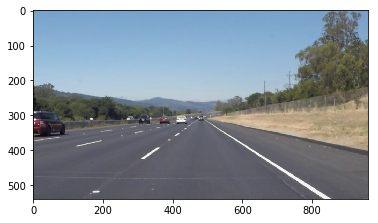

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # print(lines)
    rate = []
    left_lane_points_x = []
    left_lane_points_y = []
    right_lane_points_x = []
    right_lane_points_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            a = ((y2-y1)/(x2-x1))
            rate.append(a)
            if a > 0:
                left_lane_points_x.append(x1)
                left_lane_points_x.append(x2)
                left_lane_points_y.append(y1)
                left_lane_points_y.append(y2)
            else:
                right_lane_points_x.append(x1)
                right_lane_points_x.append(x2)
                right_lane_points_y.append(y1)
                right_lane_points_y.append(y2)
    plt.subplot(1,2,1)
    plt.scatter(left_lane_points_x, left_lane_points_y)
    plt.subplot(1,2,2)
    plt.scatter(right_lane_points_x, right_lane_points_y)
    
    model_left = np.polyfit(left_lane_points_x, left_lane_points_y, 1)
    model_right = np.polyfit(right_lane_points_x, right_lane_points_y, 1)
    print(model_left)
    print(model_right)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['out_solidWhiteCurve.jpg',
 'out_solidWhiteRight.jpg',
 'out_solidYellowCurve.jpg',
 'out_solidYellowCurve2.jpg',
 'out_solidYellowLeft.jpg',
 'out_whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
def draw_lines_polyfit(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # print(lines)
    rate = []
    left_lane_points_x = []
    left_lane_points_y = []
    right_lane_points_x = []
    right_lane_points_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            a = ((y2-y1)/(x2-x1))
            rate.append(a)
            if a > 0:
                left_lane_points_x.append(x1)
                left_lane_points_x.append(x2)
                left_lane_points_y.append(y1)
                left_lane_points_y.append(y2)
            else:
                right_lane_points_x.append(x1)
                right_lane_points_x.append(x2)
                right_lane_points_y.append(y1)
                right_lane_points_y.append(y2)
#     plt.subplot(1,2,1)
#     plt.scatter(left_lane_points_x, left_lane_points_y)
#     plt.subplot(1,2,2)
#     plt.scatter(right_lane_points_x, right_lane_points_y)
    
    model_left = np.polyfit(left_lane_points_x, left_lane_points_y, 1)
    model_right = np.polyfit(right_lane_points_x, right_lane_points_y, 1)
    print(model_left)
    print(model_right)
    
    predict_left = np.poly1d(model_left)    
    predict_left_y = predict_left(range(480))
    
    predict_right = np.poly1d(model_right)
    x_range = range(500,960)
    predict_right_y = predict_right(x_range)
    
    x0 = 0
    y0 = (int)(predict_right(x0))
    x1 = 480
    y1 = (int)(predict_right(x1))
    
    x2 = 500
    y2 = (int)(predict_left(x2))
    x3 = 960
    y3 = (int)(predict_left(x3))
    
    cv2.line(img, (x0, y0), (x1, y1), color, thickness)
    cv2.line(img, (x2, y2), (x3, y3), color, thickness)
    
#     plt.subplot(1,2,1)
#     plt.scatter(range(480), predict_left_y)
#     plt.subplot(1,2,2)
#     plt.scatter(x_range, predict_right_y)
    
    
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_polyfit(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_polyfit(line_img, lines)
    return line_img


[ 0.56824357 34.12904782]
[ -0.69434776 650.98966141]
[0.6268513  4.29159411]
[ -0.64643252 624.37235939]
[ 0.61287213 13.9034351 ]
[ -0.68718514 644.2852066 ]
[ 0.60228704 15.81653949]
[ -0.70858124 651.58250408]
[ 0.63726878 -0.35746616]
[ -0.69842178 640.05080708]
[ 0.56934821 38.70343086]
[ -0.74391313 671.56980037]
[ 0.57524765 32.29377245]
[ -0.68717397 649.39693222]
[ 0.64295798 -3.92932139]
[ -0.66768449 630.72016134]
[ 0.60671337 20.06728025]
[ -0.70084789 651.52985407]
[ 0.60455033 19.11966087]
[ -0.71535429 653.62037643]
[ 0.64346359 -5.22143087]
[ -0.70713763 643.29169419]
[ 0.58093085 30.21723697]
[ -0.76296103 677.56012163]


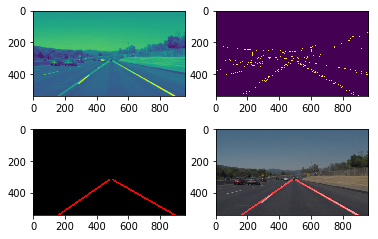

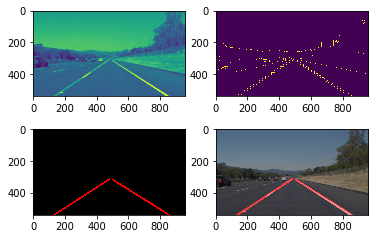

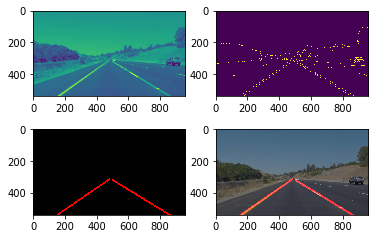

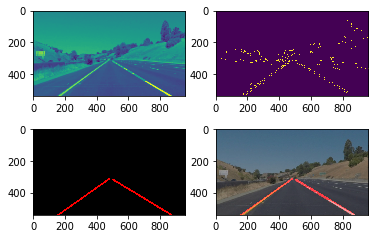

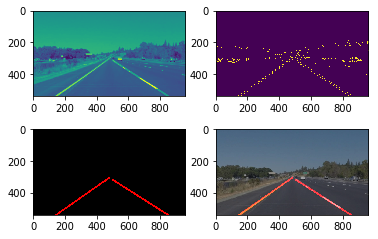

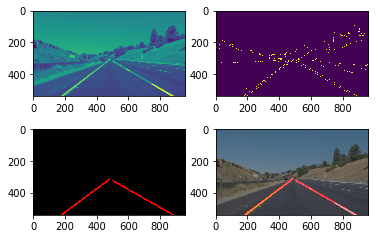

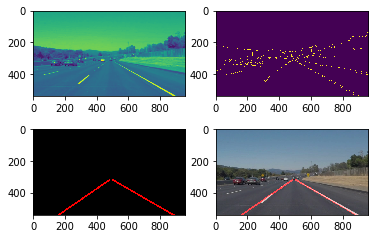

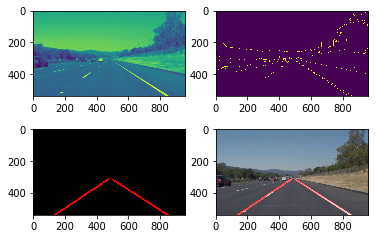

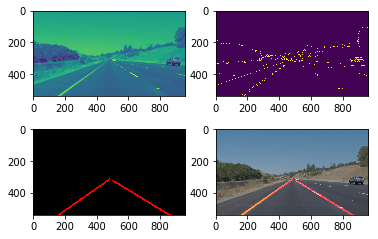

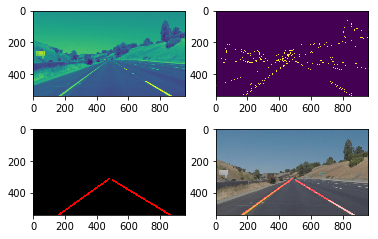

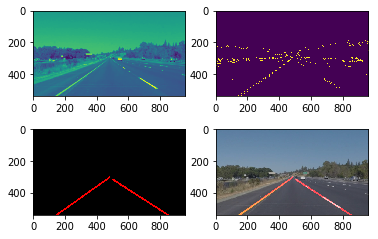

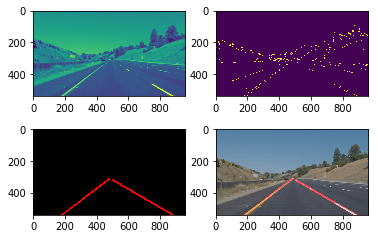

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
# Set parameters for tunning
kernel_size = 5
low_threshold = 50
high_threshold = 150
vertices = np.array([[(0,540),(480,300), (500,300), (960,540)]], dtype=np.int32)

rho = 2 # distance resolution in pixels of the Hough grid
theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

input_files = os.listdir("test_images/")

idx = 0

for file in input_files:
    # f1 = input_files[0]
    image = mpimg.imread("test_images/" + file)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size)

    plt.figure(idx)
    
    plt.subplot(2,2,1)
    plt.imshow(blur_gray)

    masked_edges = canny(blur_gray, low_threshold, high_threshold)    

    plt.subplot(2,2,2)
    plt.imshow(masked_edges)

    masked_image = region_of_interest(masked_edges, vertices)

    lines_img = hough_lines_polyfit(masked_image, rho, theta, threshold, min_line_len, max_line_gap)

    plt.subplot(2,2,3)
    plt.imshow(lines_img)

    lines_edges = weighted_img(lines_img, image, 0.8, 1, 0)

    plt.subplot(2,2,4)
    plt.imshow(lines_edges)
    
    idx += 1
    
    output_file = "test_images/" + "out_" + file
    mpimg.imsave(output_file, lines_edges)
    
    
    


In [7]:
def draw_lane_line(image):
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    vertices = np.array([[(0,540),(480,300), (500,300), (960,540)]], dtype=np.int32)

    rho = 2 # distance resolution in pixels of the Hough grid
    theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on   

    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size)
    masked_edges = canny(blur_gray, low_threshold, high_threshold)
    masked_image = region_of_interest(masked_edges, vertices)
    lines_img = hough_lines_polyfit(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    print(lines_img.shape)
    lines_edges = weighted_img(lines_img, image, 0.8, 1, 0)
    return lines_edges



[0.63036998 1.0716005 ]
[ -0.67913589 634.34214261]
(540, 960, 3)


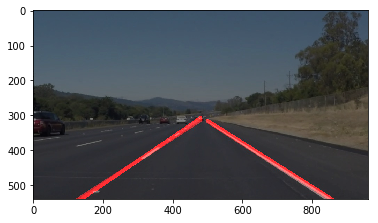

In [8]:
input_files = os.listdir("test_images/")
f1 = input_files[1]
image = mpimg.imread("test_images/" + f1)
res = draw_lane_line(image)
plt.imshow(res)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image_old(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = draw_lane_line(image)
    
    return result

In [ ]:
def compute_slope_bias(line):
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]
    
    slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)
    bias = y1 - slope * x1
    return slope, bias

def get_lane_lines(color_image):
    kernel_size = 17
    low_threshold = 50
    high_threshold = 80
    
    vertices = np.array([[(0,540),
                          (480,300), 
                          (500,300), 
                          (960,540)]], 
                        dtype=np.int32)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 15 #minimum number of pixels making up a line
    max_line_gap = 6    # maximum gap in pixels between connectable line segments
        
    gray = grayscale(color_image)
    blur_gray = gaussian_blur(gray, kernel_size)
    masked_edges = canny(blur_gray, low_threshold, high_threshold)
    detected_lines = cv2.HoughLinesP(masked_edges, rho, theta, 
                                     threshold, np.array([]), 
                                     minLineLength=min_line_len,
                                     maxLineGap=max_line_gap)
    # consider only lines with slope between 30 and 60 degrees
    candidate_lines = []
    for line in detected_lines:
        slope,_ = compute_slope_bias(line)
        if 0.5 <= abs(slope) <= 2:
            candidate_lines.append(line)
        else:
            pass
    lane_lines_lr = compute_lane_from_candidates(candidate_lines)
    return lane_lines_lr
    
def compute_lane_from_candidates(candidate_lines):
    img_shape = (960, 540)
    # separate candidate lines according to their slope
    pos_lines = []
    neg_lines = []
    pos_lines_slope = []
    neg_lines_slope = []
    pos_lines_bias = []
    neg_lines_bias = []    
    
    for l in candidate_lines:
        slope, bias = compute_slope_bias(l)
        if slope > 0:
            pos_lines.append(l)
            pos_lines_slope.append(slope)
            pos_lines_bias.append(bias)
        elif slope < 0:
            neg_lines.append(l)
            neg_lines_slope.append(slope)
            neg_lines_bias.append(bias)
    neg_bias = np.median(neg_lines_bias).astype(int)
    neg_slope = np.median(neg_lines_slope)
    x1, y1 = 0, neg_bias
    x2, y2 = -np.int32(np.round(neg_bias / neg_slope)), 0
    left_lane = [x1, y1, x2, y2]

    lane_right_bias = np.median(pos_lines_bias).astype(int)
    lane_right_slope = np.median(pos_lines_slope)
    x1, y1 = 0, lane_right_bias
    x2, y2 = np.int32(np.round((img_shape[0] - lane_right_bias) / lane_right_slope)), img_shape[0]
    right_lane = [x1, y1, x2, y2]

    return left_lane, right_lane


def smooth_lines(group_lanes):
    smoothed_lines = group_lanes
    # TODO
    return smoothed_lines


def draw_lane_line_optimize(images):
    img_height, img_width = image[0].shape[0], image[0].shape[1]
       
    group_lines = []
    
    for i in range(0, len(images)):
        lanes = get_lane_lines(images[i])
        group_lines.append(lanes)
    
    group_lines = smooth_lines(group_lanes)
    
    line_image = np.copy(images[-1])*0 # creating a blank to draw lines on   
    
    # Draw line image
    # TODO
        
    masked_image = region_of_interest(masked_edges, vertices)
    
    lines_edges = weighted_img(lines_img, image, 0.8, 1, 0)
    return lines_edges
    
    

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = draw_lane_line(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|█▊                                                                   | 6/221 [00:00<00:03, 55.82it/s, now=None]

[0.63089314 0.05393062]
[ -0.72880462 653.63072101]
(540, 960, 3)
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

[0.63089314 0.05393062]
[ -0.72880462 653.63072101]
(540, 960, 3)
[ 0.61139809 12.11976162]
[ -0.71622023 648.44939323]
(540, 960, 3)
[ 0.61634561 10.00555621]
[ -0.72217046 653.80350727]
(540, 960, 3)
[0.62928678 0.80430272]
[ -0.71955963 652.15053326]
(540, 960, 3)
[0.62339323 5.040617  ]
[ -0.72191679 649.69427731]
(540, 960, 3)
[0.62473371 4.46945644]
[ -0.71323106 646.39520311]
(540, 960, 3)
[0.62896908 0.03022561]
[ -0.73891391 657.86772302]
(540, 960, 3)
[0.6154579 6.0850779]
[ -0.71074444 645.5986283 ]
(540, 960, 3)
[0.62128002 4.15892849]
[ -0.67991547 632.79587275]
(540, 960, 3)
[ 0.63689129 -2.00153095]
[ -0.69509089 641.57569959]
(540, 960, 3)
[ 0.63952343 -1.83173799]
[ -0.68322905 639.33540052]


t:  10%|██████▊                                                             | 22/221 [00:00<00:03, 65.15it/s, now=None]

(540, 960, 3)
[0.62767664 7.17856509]
[ -0.69814449 646.40351294]
(540, 960, 3)
[0.62501201 7.68458814]
[ -0.7125239 649.1001077]
(540, 960, 3)
[ 0.64378569 -3.50419755]
[ -0.70884998 646.68372897]
(540, 960, 3)
[ 0.64776087 -6.70516012]
[ -0.71679968 647.61775144]
(540, 960, 3)
[ 0.63499956 -1.39607816]
[ -0.68824208 635.32240323]
(540, 960, 3)
[ 0.64475557 -6.58326254]
[ -0.64881742 617.93794497]
(540, 960, 3)
[  0.65253103 -11.81108817]
[ -0.61720585 605.03308574]
(540, 960, 3)
[  0.66206183 -17.24422412]
[ -0.63909207 615.2826231 ]
(540, 960, 3)
[ 0.64282375 -3.85282196]
[ -0.6883204  636.43485594]
(540, 960, 3)
[ 0.64541724 -5.39804178]
[ -0.67491395 633.67163676]
(540, 960, 3)
[ 0.64770573 -7.28074091]
[ -0.65549783 625.87652737]
(540, 960, 3)
[ 0.642169   -3.59077806]
[ -0.68947528 639.53715834]
(540, 960, 3)
[0.63527203 1.12395928]
[ -0.69344843 639.25391237]
(540, 960, 3)
[ 0.63848539 -0.73153294]
[ -0.69093461 641.01288052]


t:  18%|████████████                                                        | 39/221 [00:00<00:02, 71.50it/s, now=None]

(540, 960, 3)
[  0.65319232 -10.32542075]
[ -0.69902436 643.25367266]
(540, 960, 3)
[ 0.6468216  -7.15388888]
[ -0.70529974 645.07669965]
(540, 960, 3)
[ 0.64140653 -3.0592873 ]
[ -0.70049859 642.8415733 ]
(540, 960, 3)
[0.63241492 2.92828766]
[ -0.63215994 613.81695127]
(540, 960, 3)
[ 0.64053977 -0.68466007]
[ -0.70719123 644.93144147]
(540, 960, 3)
[ 0.6381535  -2.04883721]
[ -0.67218616 629.49729302]
(540, 960, 3)
[  0.65346125 -14.43674948]
[ -0.66132044 623.73570848]
(540, 960, 3)
[ 0.64271842 -5.57682401]
[ -0.70037068 641.56923643]
(540, 960, 3)
[0.62440191 4.72889874]
[ -0.69602759 640.57208788]
(540, 960, 3)
[0.6341596  0.20997999]
[ -0.7023887  644.71858628]
(540, 960, 3)
[ 0.64587526 -6.84708672]
[ -0.69733935 642.18636436]
(540, 960, 3)
[ 0.64048182 -2.21258079]
[ -0.68509475 639.79072611]
(540, 960, 3)
[ 0.64004876 -1.3487971 ]
[ -0.71157547 649.74361836]
(540, 960, 3)
[  0.65380159 -10.59461502]
[ -0.69960406 644.51920096]
(540, 960, 3)
[ 0.64047512 -3.57456405]
[ -0.724

t:  21%|██████████████▍                                                     | 47/221 [00:00<00:02, 73.13it/s, now=None]

(540, 960, 3)
[0.63238708 3.22567201]
[ -0.72217549 650.12552366]
(540, 960, 3)
[ 0.64313991 -5.83015832]
[ -0.67321333 629.48114179]
(540, 960, 3)
[  0.65381479 -12.54181685]
[ -0.63983808 615.25238868]
(540, 960, 3)
[ 0.64930288 -8.15943019]
[ -0.70590879 641.01150596]
(540, 960, 3)
[ 0.64151971 -3.55274081]
[ -0.70468176 641.67780474]
(540, 960, 3)
[  0.65788617 -13.50125246]
[ -0.67110511 630.36847706]
(540, 960, 3)
[ 0.65086335 -9.47621024]
[ -0.69175405 638.11068925]
(540, 960, 3)
[ 0.64566957 -6.64043424]
[ -0.68509962 635.9172352 ]
(540, 960, 3)
[ 0.65149028 -9.69005889]
[ -0.7097916  644.78864101]
(540, 960, 3)
[  0.65900114 -14.50802233]
[ -0.69837511 640.8383653 ]
(540, 960, 3)
[ 0.64430864 -6.18492167]
[ -0.70966191 643.48945098]
(540, 960, 3)
[  0.65524728 -13.71200809]
[ -0.70366343 640.9128361 ]
(540, 960, 3)
[ 0.63394168 -0.60035493]
[ -0.64556541 616.23871039]


t:  28%|███████████████████                                                 | 62/221 [00:00<00:02, 69.79it/s, now=None]

(540, 960, 3)
[ 0.65293715 -9.91574396]
[ -0.60944683 601.31026665]
(540, 960, 3)
[ 0.65134041 -7.9607976 ]
[ -0.64866281 616.37655721]
(540, 960, 3)
[ 0.63775819 -0.5041747 ]
[ -0.64063124 615.43683191]
(540, 960, 3)
[ 0.64483276 -2.48908813]
[ -0.65922125 623.82506427]
(540, 960, 3)
[ 0.65470814 -8.19343095]
[ -0.66578078 627.72224632]
(540, 960, 3)
[ 0.64176754 -1.66395906]
[ -0.6638042 626.4950424]
(540, 960, 3)
[0.64030212 0.02408924]
[ -0.66300901 628.73217276]
(540, 960, 3)
[ 0.65660436 -9.38842548]
[ -0.68171039 633.92418419]
(540, 960, 3)
[ 0.64866148 -4.40486146]
[ -0.66994086 629.74542165]
(540, 960, 3)
[ 0.64580516 -2.93998289]
[ -0.68545634 634.42595878]
(540, 960, 3)
[ 0.65315346 -5.80897147]
[ -0.67548856 631.55788653]
(540, 960, 3)
[  0.66361996 -14.5827338 ]
[ -0.62270872 608.3059614 ]
(540, 960, 3)
[  0.65886735 -12.49798727]
[ -0.63611944 614.47946961]
(540, 960, 3)
[ 0.64890663 -5.51183735]
[ -0.6356275 610.9259567]
(540, 960, 3)
[ 0.64487023 -4.91755098]
[-5.796716

t:  35%|████████████████████████                                            | 78/221 [00:01<00:01, 73.12it/s, now=None]

(540, 960, 3)
[  0.66128058 -12.5126613 ]
[ -0.64684606 618.87779672]
(540, 960, 3)
[  0.65920541 -10.80916554]
[ -0.67266111 627.52928573]
(540, 960, 3)
[  0.67472543 -21.02936801]
[ -0.64286152 617.51750645]
(540, 960, 3)
[  0.66002636 -12.37058521]
[ -0.64974263 619.98559172]
(540, 960, 3)
[ 0.65168916 -6.13029133]
[ -0.65759166 623.87483623]
(540, 960, 3)
[  0.65935907 -11.17943358]
[ -0.6640793  625.06201546]
(540, 960, 3)
[ 0.65347631 -7.13697907]
[ -0.66548736 623.94896684]
(540, 960, 3)
[  0.66626752 -12.60177822]
[ -0.63143031 610.77782524]
(540, 960, 3)
[  0.66734434 -16.06189645]
[-5.87457669e-01  5.90196222e+02]
(540, 960, 3)
[  0.67365426 -17.3116238 ]
[-5.74571577e-01  5.85831256e+02]
(540, 960, 3)
[  0.67655155 -18.18423321]
[ -0.66381551 622.34806956]
(540, 960, 3)
[  0.67599499 -19.82923367]
[ -0.64847997 615.80442076]
(540, 960, 3)
[  0.68341456 -24.84712407]
[ -0.62806846 609.17321766]
(540, 960, 3)
[  0.68778033 -26.3904832 ]
[ -0.66580598 622.79181441]


t:  43%|████████████████████████████▉                                       | 94/221 [00:01<00:01, 74.18it/s, now=None]

(540, 960, 3)
[  0.67470931 -19.43945687]
[ -0.63855198 613.96451968]
(540, 960, 3)
[  0.6711949  -17.46281191]
[ -0.63108691 612.10457082]
(540, 960, 3)
[  0.68138792 -24.60159057]
[ -0.65097093 619.76186738]
(540, 960, 3)
[  0.67275765 -16.49897742]
[ -0.66330324 622.26208089]
(540, 960, 3)
[  0.67553862 -18.63939312]
[ -0.64024019 617.41331072]
(540, 960, 3)
[  0.67776675 -19.59413816]
[ -0.63222125 611.9588037 ]
(540, 960, 3)
[  0.68272951 -22.35596004]
[ -0.6206005  606.09849054]
(540, 960, 3)
[  0.68795949 -24.96102286]
[ -0.66551659 624.7958401 ]
(540, 960, 3)
[  0.69908814 -32.26004142]
[ -0.65246365 619.62828272]
(540, 960, 3)
[  0.68772198 -25.86724784]
[ -0.64028266 615.16414485]
(540, 960, 3)
[  0.69471637 -29.55969698]
[ -0.62199198 609.16991229]
(540, 960, 3)
[  0.68696819 -26.50282002]
[ -0.62446501 609.49328769]
(540, 960, 3)
[  0.6889578  -28.51658507]
[ -0.66117876 622.7689669 ]
(540, 960, 3)
[  0.70289857 -36.16305465]
[ -0.64327858 616.67185047]
(540, 960, 3)
[  0.6

t:  50%|█████████████████████████████████▎                                 | 110/221 [00:01<00:01, 74.25it/s, now=None]

(540, 960, 3)
[  0.67931523 -21.99466895]
[ -0.66418673 623.75349882]
(540, 960, 3)
[  0.69675604 -36.87199433]
[ -0.647674  616.3019076]
(540, 960, 3)
[  0.68036199 -25.12859116]
[ -0.64665421 619.58126142]
(540, 960, 3)
[  0.69495357 -32.46022945]
[ -0.61828861 606.55775582]
(540, 960, 3)
[  0.69713179 -32.53979479]
[ -0.66911314 628.34974072]
(540, 960, 3)
[  0.69081423 -28.65837423]
[ -0.66250279 626.58978363]
(540, 960, 3)
[  0.67537941 -21.27808381]
[ -0.63686688 617.12280303]
(540, 960, 3)
[  0.67669815 -23.94306623]
[ -0.67410789 630.85223592]
(540, 960, 3)
[  0.68865693 -30.8282399 ]
[ -0.67443923 630.68770345]
(540, 960, 3)
[  0.67218255 -21.53342344]
[ -0.67348684 630.65245123]
(540, 960, 3)
[  0.67666666 -24.94142281]
[ -0.67200138 629.34447675]
(540, 960, 3)
[  0.67764927 -24.1879262 ]
[ -0.66722284 628.88691207]
(540, 960, 3)
[  0.69168379 -31.14313964]
[ -0.66991199 631.10028765]
(540, 960, 3)
[  0.68058331 -25.11012173]
[ -0.68485537 636.55790731]


t:  53%|███████████████████████████████████▊                               | 118/221 [00:01<00:01, 72.91it/s, now=None]

(540, 960, 3)
[  0.6721218  -21.26376495]
[ -0.6469784  620.69894768]
(540, 960, 3)
[  0.67249711 -22.03385662]
[-5.35031685e-01  5.69950564e+02]
(540, 960, 3)
[  0.66724736 -19.14449349]
[-5.38985901e-01  5.70999100e+02]
(540, 960, 3)
[  0.67534119 -24.21352813]
[-5.57581512e-01  5.80019920e+02]
(540, 960, 3)
[  0.65702125 -13.06764041]
[ -0.6038267 602.1659573]
(540, 960, 3)
[  0.65425447 -11.83873954]
[ -0.60304016 601.962005  ]
(540, 960, 3)
[  0.66110875 -16.65487499]
[ -0.61800522 608.91605392]
(540, 960, 3)
[  0.6648294  -17.74375162]
[ -0.66332274 627.56079091]
(540, 960, 3)
[ 0.64552855 -6.01979429]
[ -0.6673614  630.40783942]
(540, 960, 3)
[ 0.64908568 -9.59335198]
[ -0.67232505 633.61927706]
(540, 960, 3)
[ 0.64603936 -5.65165722]
[ -0.6625245  629.53658025]
(540, 960, 3)
[ 0.64127281 -2.24364086]
[ -0.6654194 629.985921 ]
(540, 960, 3)
[ 0.6420151  -3.89400973]
[ -0.65973993 628.39289677]


t:  61%|████████████████████████████████████████▌                          | 134/221 [00:01<00:01, 72.37it/s, now=None]

(540, 960, 3)
[0.63254381 2.8311706 ]
[ -0.65375363 623.59893889]
(540, 960, 3)
[ 0.63409586 -1.29952945]
[ -0.6001569  600.01478739]
(540, 960, 3)
[ 0.63270626 -1.43697048]
[ -0.60862572 604.09562806]
(540, 960, 3)
[0.62959139 1.30676475]
[ -0.658505   628.24836131]
(540, 960, 3)
[0.62974872 0.68195621]
[ -0.69406785 642.4350071 ]
(540, 960, 3)
[ 0.63872656 -4.7732128 ]
[ -0.64507868 623.62540317]
(540, 960, 3)
[ 0.63697782 -1.86454287]
[ -0.69247957 643.77697146]
(540, 960, 3)
[ 0.63518902 -1.58480233]
[ -0.69417705 644.20237311]
(540, 960, 3)
[0.63175011 0.20447842]
[ -0.68606573 640.17286179]
(540, 960, 3)
[0.63393861 0.14689316]
[ -0.69259232 641.49872148]
(540, 960, 3)
[ 0.63765678 -6.99356604]
[ -0.69251744 640.35411753]
(540, 960, 3)
[ 0.64181132 -7.88137698]
[ -0.69024394 640.38162029]
(540, 960, 3)
[ 0.63168435 -1.71812349]
[ -0.69721706 640.53492202]
(540, 960, 3)
[ 0.61341237 13.24258085]
[ -0.63436647 614.72829255]


t:  68%|█████████████████████████████████████████████▍                     | 150/221 [00:02<00:00, 72.76it/s, now=None]

(540, 960, 3)
[0.62517475 4.00152548]
[ -0.70244174 645.3097431 ]
(540, 960, 3)
[ 0.6390257  -4.27349291]
[ -0.67509036 634.95537227]
(540, 960, 3)
[ 0.63031313 -0.12589436]
[ -0.6323047  619.03261476]
(540, 960, 3)
[ 0.63527026 -2.55906561]
[ -0.67114259 634.89142812]
(540, 960, 3)
[0.62759305 3.89836957]
[ -0.68268536 640.63297633]
(540, 960, 3)
[ 0.63833987 -3.10421834]
[ -0.69024689 644.32831794]
(540, 960, 3)
[ 0.61366746 13.00050628]
[ -0.71353643 653.11721393]
(540, 960, 3)
[ 0.60960157 11.83476687]
[ -0.71679959 652.86729329]
(540, 960, 3)
[0.62379641 0.61297102]
[ -0.71762542 652.94690777]
(540, 960, 3)
[0.61527589 7.1573459 ]
[ -0.71575366 652.07184475]
(540, 960, 3)
[0.62355358 3.1943743 ]
[ -0.64395408 620.62903628]
(540, 960, 3)
[0.61452086 8.86252674]
[ -0.72694125 656.82145039]
(540, 960, 3)
[ 0.61146316 10.55177266]
[ -0.65965298 627.96963787]
(540, 960, 3)


t:  75%|██████████████████████████████████████████████████▎                | 166/221 [00:02<00:00, 72.33it/s, now=None]

[0.62441906 0.50886918]
[ -0.61599606 610.11253196]
(540, 960, 3)
[0.61708944 6.85292943]
[ -0.66813726 633.18320386]
(540, 960, 3)
[ 0.60636024 13.19927993]
[ -0.6909727  642.03904505]
(540, 960, 3)
[0.62261828 1.17695897]
[ -0.69336484 645.0253213 ]
(540, 960, 3)
[ 0.62522119 -0.17229251]
[ -0.68909405 642.51035633]
(540, 960, 3)
[0.61510349 6.78405099]
[ -0.71644714 654.58388279]
(540, 960, 3)
[0.62367848 1.22620814]
[ -0.71796306 655.03214936]
(540, 960, 3)
[ 0.59841825 19.17596772]
[ -0.72705583 659.89338483]
(540, 960, 3)
[ 0.60016568 15.30321211]
[ -0.73264515 662.8613503 ]
(540, 960, 3)
[ 0.60012615 13.87700908]
[-5.83592876e-01  5.97998509e+02]
(540, 960, 3)
[ 0.59463405 18.06226289]
[ -0.61134813 609.36297438]
(540, 960, 3)
[ 0.59242009 18.5640134 ]
[ -0.70754405 650.56600094]
(540, 960, 3)
[ 0.59521986 18.92487192]
[-5.22286040e-01  5.68169578e+02]
(540, 960, 3)
[ 0.58746448 21.76002889]
[ -0.69354838 648.78078857]


t:  79%|████████████████████████████████████████████████████▊              | 174/221 [00:02<00:00, 71.80it/s, now=None]

(540, 960, 3)
[ 0.58822575 24.47407358]
[ -0.67138759 640.11089047]
(540, 960, 3)
[ 0.59547464 20.26885266]
[ -0.69998411 652.70111971]
(540, 960, 3)
[ 0.59307801 19.79422233]
[ -0.71054387 657.05142517]
(540, 960, 3)
[ 0.58898202 23.1770861 ]
[ -0.74694973 671.50236701]
(540, 960, 3)
[ 0.59495799 20.17625933]
[ -0.73538698 669.3050872 ]
(540, 960, 3)
[ 0.59012187 21.30156644]
[ -0.73801422 668.46485731]
(540, 960, 3)
[ 0.5969563  17.46054011]
[ -0.74325587 672.53625774]
(540, 960, 3)
[ 0.58392341 25.36072973]
[ -0.63050785 619.89103744]
(540, 960, 3)
[ 0.57866187 28.30052965]
[ -0.67218494 637.2365399 ]
(540, 960, 3)
[ 0.59332006 19.26909891]
[ -0.61144925 610.63373736]
(540, 960, 3)
[ 0.5949359  17.89419026]
[ -0.6167363  610.85042521]
(540, 960, 3)
[ 0.59177974 21.59672314]
[ -0.7100595  655.33023279]
(540, 960, 3)
[ 0.60278897 14.51123605]
[ -0.74556446 670.93588537]


t:  86%|█████████████████████████████████████████████████████████▌         | 190/221 [00:02<00:00, 72.63it/s, now=None]

(540, 960, 3)
[ 0.59337736 17.8737382 ]
[ -0.73305899 665.3382727 ]
(540, 960, 3)
[ 0.57661531 29.39722617]
[ -0.78113164 684.04322754]
(540, 960, 3)
[ 0.57854423 27.64445914]
[ -0.74706347 671.13271282]
(540, 960, 3)
[ 0.58407034 24.65075359]
[ -0.77937752 684.75420952]
(540, 960, 3)
[0.61904484 3.82480201]
[ -0.78054901 683.47073001]
(540, 960, 3)
[ 0.58681556 22.08483856]
[ -0.77465015 682.79940227]
(540, 960, 3)
[ 0.60114863 12.72282992]
[ -0.6760668  636.20647709]
(540, 960, 3)
[ 0.58939464 20.64575672]
[ -0.70543872 648.96489052]
(540, 960, 3)
[ 0.57095528 30.96382508]
[ -0.75180134 668.01236519]
(540, 960, 3)
[ 0.57902546 23.97486696]
[ -0.79012346 682.37407407]
(540, 960, 3)
[ 0.57053086 27.50490016]
[ -0.72856004 655.75445924]
(540, 960, 3)
[ 0.57656869 24.55722911]
[ -0.72188157 656.37677712]
(540, 960, 3)
[ 0.56937509 29.69737605]
[ -0.72061611 657.08812053]
(540, 960, 3)
[ 0.5748091  28.68566644]
[ -0.77849504 683.31640611]


t:  93%|██████████████████████████████████████████████████████████████▍    | 206/221 [00:02<00:00, 71.83it/s, now=None]

(540, 960, 3)
[ 0.57619199 30.14801649]
[ -0.77173114 681.44124879]
(540, 960, 3)
[ 0.58514533 24.70192736]
[ -0.76886872 681.58175702]
(540, 960, 3)
[ 0.5864147  23.43906129]
[ -0.74873521 673.4289938 ]
(540, 960, 3)
[ 0.57851196 29.0164288 ]
[ -0.76906627 680.4038799 ]
(540, 960, 3)
[ 0.58467915 24.40145535]
[ -0.60925881 607.7427669 ]
(540, 960, 3)
[ 0.5678208  34.95937468]
[ -0.67281075 636.51829721]
(540, 960, 3)
[ 0.58690212 22.78395114]
[-5.93147285e-01  6.01504501e+02]
(540, 960, 3)
[ 0.56289361 37.73996592]
[ -0.8294697  706.56310417]
(540, 960, 3)
[ 0.5739591  30.94618015]
[ -0.74279492 664.9841505 ]
(540, 960, 3)
[ 0.57215821 31.03737181]
[ -0.69214152 647.85444647]
(540, 960, 3)
[ 0.56721395 34.06187999]
[ -0.7380964 664.4707134]
(540, 960, 3)
[ 0.57684758 25.78131008]
[ -0.7607574  674.30330196]
(540, 960, 3)
[ 0.57307045 29.49405344]
[ -0.75832945 674.64024867]


t:  97%|████████████████████████████████████████████████████████████████▉  | 214/221 [00:02<00:00, 72.79it/s, now=None]

(540, 960, 3)
[ 0.56996131 29.61314438]
[ -0.76042599 676.27763856]
(540, 960, 3)
[ 0.57077191 30.31196112]
[ -0.76314363 674.91913828]
(540, 960, 3)
[ 0.56769638 31.35534386]
[ -0.78752464 685.36569072]
(540, 960, 3)
[ 0.5547447  38.93418936]
[ -0.67392204 635.94807918]
(540, 960, 3)
[ 0.55013292 41.58829381]
[ -0.6116706  609.58648572]
(540, 960, 3)
[ 0.56306173 36.83898836]
[-5.80013478e-01  5.96434407e+02]
(540, 960, 3)
[ 0.56602641 34.74447746]
[ -0.66087878 630.10118766]
(540, 960, 3)
[ 0.56490269 36.60126681]
[ -0.70060247 648.86816493]
(540, 960, 3)
[ 0.56683564 34.94115603]
[ -0.66852301 637.80921878]
(540, 960, 3)
[ 0.5630315  37.89893113]
[ -0.66641244 639.39106205]
(540, 960, 3)
[ 0.5700999 34.4047758]
[ -0.7380893 669.096114 ]
(540, 960, 3)
[ 0.56512013 37.84812999]
[ -0.75374743 675.3213451 ]
(540, 960, 3)
[ 0.56335034 37.09779173]
[ -0.72927306 667.52530317]
(540, 960, 3)
[ 0.57060936 33.83875633]
[ -0.75048257 673.93789692]


(540, 960, 3)
[ 0.55746009 41.56234273]
[ -0.75614638 675.04504232]
(540, 960, 3)
Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 3.28 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▊                                                                    | 8/681 [00:00<00:09, 70.57it/s, now=None]

[  0.70172782 -39.39388757]
[ -0.63507587 614.47532533]
(540, 960, 3)
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

[  0.70172782 -39.39388757]
[ -0.63507587 614.47532533]
(540, 960, 3)
[  0.69423806 -34.27714911]
[ -0.63014666 613.44574719]
(540, 960, 3)
[  0.67832224 -24.48245301]
[ -0.6350894 616.0855218]
(540, 960, 3)
[  0.67915929 -25.12050396]
[ -0.62130221 610.53328364]
(540, 960, 3)
[  0.65801315 -14.69081958]
[ -0.62627824 614.94496472]
(540, 960, 3)
[  0.67878457 -25.87329426]
[ -0.64781638 623.49948386]
(540, 960, 3)
[  0.6830433  -27.98707319]
[ -0.65032978 624.20150969]
(540, 960, 3)
[  0.69826062 -37.01838739]
[ -0.66014658 627.28580038]
(540, 960, 3)
[  0.68309962 -29.50410148]
[ -0.65875664 627.12502065]
(540, 960, 3)
[  0.69127766 -35.80293928]
[ -0.65034508 622.86415453]
(540, 960, 3)
[  0.67742077 -28.26607922]
[ -0.65893492 625.80443232]
(540, 960, 3)
[  0.6634767  -19.86964545]
[ -0.

t:   4%|██▌                                                                 | 26/681 [00:00<00:08, 76.59it/s, now=None]

(540, 960, 3)
[  0.6576312  -16.65625174]
[ -0.6710856 630.985885 ]
(540, 960, 3)
[  0.64923613 -12.00639168]
[ -0.67640472 633.99018718]
(540, 960, 3)
[ 0.63998738 -6.60987204]
[ -0.68546966 637.31503655]
(540, 960, 3)
[ 0.64387884 -8.97557991]
[ -0.684657   636.39825364]
(540, 960, 3)
[  0.68516518 -31.90768359]
[ -0.67667198 635.08979727]
(540, 960, 3)
[  0.69638201 -38.36836659]
[ -0.68175532 634.43290195]
(540, 960, 3)
[  0.69480541 -37.03366679]
[ -0.70341281 645.09617793]
(540, 960, 3)
[  0.66832879 -23.80490972]
[ -0.68900243 637.38988166]
(540, 960, 3)
[  0.65959014 -19.90808962]
[ -0.69545456 640.04227588]
(540, 960, 3)
[  0.67332753 -27.68543618]
[ -0.6952399  638.88200253]
(540, 960, 3)
[  0.66574208 -23.07579799]
[ -0.68831672 636.02338262]
(540, 960, 3)
[  0.64495666 -11.63705395]
[ -0.68522324 636.33621384]
(540, 960, 3)
[ 0.64183306 -8.15478156]
[ -0.69751481 641.0354568 ]
(540, 960, 3)
[ 0.63484697 -5.47107063]
[ -0.72223209 651.00941756]
(540, 960, 3)
[ 0.63754418 -9.

t:   6%|████▍                                                               | 44/681 [00:00<00:08, 79.57it/s, now=None]

(540, 960, 3)
[ 0.63135581 -5.28148712]
[ -0.71512913 648.08404388]
(540, 960, 3)
[ 0.62524598 -3.39661359]
[ -0.70508728 643.07336954]
(540, 960, 3)
[  0.66628137 -24.88488934]
[ -0.72457797 651.42332071]
(540, 960, 3)
[  0.68718492 -37.87885092]
[ -0.72289363 649.36042968]
(540, 960, 3)
[  0.66020814 -23.95933049]
[ -0.71759541 647.51364426]
(540, 960, 3)
[  0.6581275  -21.31169341]
[ -0.74251031 657.7168266 ]
(540, 960, 3)
[  0.66114326 -24.3299057 ]
[ -0.74789822 659.7920539 ]
(540, 960, 3)
[  0.64695892 -16.49517036]
[ -0.74438146 658.6697676 ]
(540, 960, 3)
[  0.63925888 -12.61073377]
[ -0.74536984 656.94219763]
(540, 960, 3)
[ 0.62631462 -3.87292985]
[ -0.74224753 654.83510655]
(540, 960, 3)
[ 0.61812416 -0.02703953]
[ -0.74219057 655.65641911]
(540, 960, 3)
[ 0.62270564 -3.23003417]
[ -0.72465385 647.07780673]
(540, 960, 3)
[ 0.62604541 -6.53547554]
[ -0.73498086 652.45039132]
(540, 960, 3)
[ 0.62161243 -2.27758229]
[ -0.73708166 653.01235551]
(540, 960, 3)
[  0.67074605 -28.94

t:   7%|█████                                                               | 51/681 [00:00<00:08, 72.35it/s, now=None]

(540, 960, 3)
[  0.69975126 -41.28999575]
[ -0.73120332 650.58432975]
(540, 960, 3)
[  0.65335493 -15.93924382]
[ -0.73171506 652.66773472]
(540, 960, 3)
[ 0.63034608 -3.65571266]
[ -0.73657844 653.74510782]
(540, 960, 3)
[ 0.64011719 -8.07819753]
[ -0.74406355 656.5228328 ]
(540, 960, 3)
[ 0.62684303 -1.2698038 ]
[ -0.74284327 656.28672866]
(540, 960, 3)
[0.62284812 0.03479212]
[ -0.73206875 650.00034316]
(540, 960, 3)
[ 0.62744457 -3.76951648]
[ -0.7504425  656.99540422]
(540, 960, 3)
[ 0.62331299 -0.01402732]
[ -0.7264863  647.72396644]
(540, 960, 3)
[0.61117685 8.33525477]
[ -0.72664549 648.67508845]
(540, 960, 3)
[0.6162376  5.61374306]
[ -0.71884276 646.5560172 ]
(540, 960, 3)
[ 0.60743718 10.46840247]
[ -0.7327934  651.74742998]
(540, 960, 3)
[  0.65446293 -14.8693646 ]
[ -0.73580902 652.95241315]
(540, 960, 3)
[ 0.63589864 -4.32287916]
[ -0.72040135 646.0769274 ]


t:  10%|██████▋                                                             | 67/681 [00:00<00:08, 74.44it/s, now=None]

(540, 960, 3)
[  0.65280608 -14.19199207]
[ -0.73886982 655.07014812]
(540, 960, 3)
[ 0.63428655 -3.49078278]
[ -0.73046229 651.12672292]
(540, 960, 3)
[ 0.64267674 -8.47103363]
[ -0.71476997 646.63133748]
(540, 960, 3)
[ 0.64528882 -9.14347221]
[ -0.72538386 649.58437808]
(540, 960, 3)
[ 0.63898399 -7.01388539]
[ -0.70900096 640.89865757]
(540, 960, 3)
[ 0.62944931 -2.06251522]
[ -0.70482308 638.65631127]
(540, 960, 3)
[0.62404188 1.60015943]
[ -0.71205073 641.97943234]
(540, 960, 3)
[ 0.63242838 -2.88379249]
[ -0.70667121 641.49551669]
(540, 960, 3)
[0.61673521 6.67149738]
[ -0.71577823 644.37496982]
(540, 960, 3)
[0.62262279 4.42086765]
[ -0.71876886 646.1592929 ]
(540, 960, 3)
[  0.70294766 -39.83323359]
[ -0.70422506 640.74757003]
(540, 960, 3)
[  0.70201946 -38.62586745]
[ -0.69729209 638.62336881]
(540, 960, 3)
[  0.67434839 -23.42077692]
[ -0.69996761 639.87394478]
(540, 960, 3)
[  0.65345749 -13.15906456]
[ -0.70768857 642.3718667 ]


t:  12%|████████▎                                                           | 83/681 [00:01<00:08, 73.45it/s, now=None]

(540, 960, 3)
[  0.65033716 -10.59420448]
[ -0.70465905 641.8510441 ]
(540, 960, 3)
[  0.65261634 -11.80308828]
[ -0.70825583 644.30273607]
(540, 960, 3)
[ 0.64791491 -8.43487383]
[ -0.71974926 648.86156116]
(540, 960, 3)
[ 0.64237558 -5.66718057]
[ -0.70520949 641.79810707]
(540, 960, 3)
[ 0.64808106 -8.87736894]
[ -0.70895755 644.48149144]
(540, 960, 3)
[ 0.64214192 -5.22332989]
[ -0.69773816 639.90486073]
(540, 960, 3)
[ 0.63585438 -2.35378027]
[ -0.71799752 646.89186341]
(540, 960, 3)
[ 0.63568975 -0.85436963]
[ -0.71108684 644.97725456]
(540, 960, 3)
[ 0.63193756 -0.30264907]
[ -0.72131366 648.44855051]
(540, 960, 3)
[  0.66277074 -15.19668832]
[ -0.70766393 642.19977105]
(540, 960, 3)
[  0.66877845 -19.75006043]
[ -0.70017169 640.32465298]
(540, 960, 3)
[  0.68039023 -27.7385681 ]
[ -0.70736959 641.24652861]
(540, 960, 3)
[  0.6838924  -28.29183081]
[ -0.68736698 633.3423813 ]
(540, 960, 3)
[  0.65994817 -15.3282096 ]
[ -0.69907209 638.2811256 ]


t:  15%|█████████▉                                                          | 99/681 [00:01<00:07, 73.07it/s, now=None]

(540, 960, 3)
[  0.67050316 -20.77591877]
[ -0.71119611 642.25725937]
(540, 960, 3)
[  0.66231995 -17.23771293]
[ -0.69195197 637.93110891]
(540, 960, 3)
[ 0.64417213 -7.81070966]
[ -0.68133302 633.88689009]
(540, 960, 3)
[ 0.64317615 -6.03598087]
[ -0.69617897 637.31548092]
(540, 960, 3)
[ 0.64615448 -7.81815547]
[ -0.67982779 631.88067582]
(540, 960, 3)
[ 0.64760959 -7.71545705]
[ -0.6916845 635.8061572]
(540, 960, 3)
[  0.6549123  -10.64829397]
[ -0.6967061  639.90295071]
(540, 960, 3)
[  0.66108552 -18.09207869]
[ -0.68650647 636.20477831]
(540, 960, 3)
[  0.68309195 -23.51047721]
[ -0.69228188 640.06200318]
(540, 960, 3)
[  0.68941517 -27.2090992 ]
[ -0.69317006 639.64882569]
(540, 960, 3)
[  0.71784002 -44.48927777]
[ -0.69518799 640.78103825]
(540, 960, 3)
[  0.66758013 -16.5396645 ]
[ -0.69868902 642.85703281]
(540, 960, 3)
[  0.65862852 -11.24083543]
[ -0.70049823 642.50726392]
(540, 960, 3)
[  0.66457419 -15.06904138]
[ -0.71070926 646.38950813]


t:  16%|██████████▌                                                        | 107/681 [00:01<00:07, 72.50it/s, now=None]

(540, 960, 3)
[ 0.64913924 -7.920076  ]
[ -0.69866837 641.87324747]
(540, 960, 3)
[ 0.64548608 -5.61020312]
[ -0.70289494 643.19446365]
(540, 960, 3)
[ 0.64797505 -7.4264267 ]
[ -0.69244955 638.75842707]
(540, 960, 3)
[ 0.63833146 -2.20555094]
[ -0.69990761 641.77985341]
(540, 960, 3)
[ 0.65062299 -9.0540065 ]
[ -0.67862755 632.14766529]
(540, 960, 3)
[ 0.63751901 -1.62172488]
[ -0.68283634 633.4950304 ]
(540, 960, 3)
[ 0.64626403 -6.61176337]
[ -0.69020908 636.43404301]
(540, 960, 3)
[  0.67466259 -21.95560514]
[ -0.69116914 637.09070762]
(540, 960, 3)
[  0.67700923 -22.35526602]
[ -0.68714647 636.43423845]
(540, 960, 3)
[  0.65730985 -12.3722973 ]
[ -0.69974343 641.69539813]
(540, 960, 3)
[  0.65683998 -10.30589556]
[ -0.69958689 642.52800284]
(540, 960, 3)
[  0.66516924 -15.56163349]
[ -0.69302435 639.77830346]
(540, 960, 3)
[ 0.64880647 -6.43507374]
[ -0.67100604 631.82040063]
(540, 960, 3)
[ 0.6531244  -9.51257971]
[ -0.67467094 634.03512022]


t:  18%|████████████                                                       | 123/681 [00:01<00:07, 71.12it/s, now=None]

(540, 960, 3)
[ 0.63897212 -1.34481477]
[ -0.68749972 640.44363829]
(540, 960, 3)
[ 0.65290809 -9.47104967]
[ -0.68725149 639.44439646]
(540, 960, 3)
[ 0.63469433 -0.2339542 ]
[ -0.69240596 640.91726778]
(540, 960, 3)
[ 0.63781718 -4.65511369]
[ -0.68313562 636.10328568]
(540, 960, 3)
[ 0.63697122 -1.48440099]
[ -0.67402307 633.31032913]
(540, 960, 3)
[  0.67442198 -21.76780288]
[ -0.66766345 632.81830044]
(540, 960, 3)
[ 0.63896358 -3.59144681]
[ -0.69169913 640.8534074 ]
(540, 960, 3)
[ 0.64803297 -8.66140569]
[ -0.71277447 648.80917939]
(540, 960, 3)
[ 0.64812802 -8.2221043 ]
[ -0.70225864 644.66291917]
(540, 960, 3)
[ 0.6472423  -7.01846875]
[ -0.68365553 639.25149344]
(540, 960, 3)
[ 0.64315355 -4.99955176]
[ -0.68670375 637.70681261]
(540, 960, 3)
[ 0.64694478 -8.5757347 ]
[ -0.69835432 645.18909226]
(540, 960, 3)
[0.63112685 1.85025264]
[ -0.66969045 635.4295431 ]


t:  19%|████████████▉                                                      | 131/681 [00:01<00:07, 70.40it/s, now=None]

(540, 960, 3)
[  0.65632448 -13.89826271]
[ -0.67999052 637.7064381 ]
(540, 960, 3)
[ 0.63236895 -0.07872822]
[ -0.6974887  645.69405629]
(540, 960, 3)
[0.63052429 1.05120793]
[ -0.68495551 637.70357604]
(540, 960, 3)
[0.62268802 6.91643826]
[ -0.68319768 638.45764318]
(540, 960, 3)
[0.62863634 4.05445826]
[ -0.67086867 635.33223536]
(540, 960, 3)
[ 0.58012566 29.21219632]
[ -0.68414946 638.41914653]
(540, 960, 3)
[ 0.58542408 24.55455887]
[ -0.70003045 645.39956464]
(540, 960, 3)
[ 0.5863954  25.14132243]
[ -0.69664263 643.39292546]
(540, 960, 3)
[0.62856838 2.56121117]
[ -0.67720457 638.08973626]
(540, 960, 3)
[  0.67228353 -24.26959574]
[ -0.68499199 640.09274708]
(540, 960, 3)
[ 0.61134232 16.63302258]
[ -0.70082238 645.75173155]
(540, 960, 3)
[0.63345335 1.40457732]
[ -0.67431353 637.43809081]


t:  22%|██████████████▍                                                    | 147/681 [00:01<00:07, 70.08it/s, now=None]

(540, 960, 3)
[0.62710994 5.55426922]
[ -0.69642786 643.56966562]
(540, 960, 3)
[  0.65353466 -12.23614969]
[ -0.67304124 636.47042181]
(540, 960, 3)
[ 0.63807199 -3.51648599]
[ -0.65900278 632.04101575]
(540, 960, 3)
[0.63053352 3.32847498]
[ -0.67861994 637.73710335]
(540, 960, 3)
[2.31269014e-01 2.66252629e+02]
[ -0.69768421 644.573149  ]
(540, 960, 3)
[ 0.58738877 26.08683259]
[ -0.69012063 643.68675554]
(540, 960, 3)
[ 0.53281602 55.14300644]
[ -0.69821278 643.3388293 ]
(540, 960, 3)
[0.61993106 5.93248175]
[ -0.68281488 639.50907864]
(540, 960, 3)
[ 0.61691881 10.86378617]
[ -0.67136454 636.12957373]
(540, 960, 3)
[  0.65631591 -14.88229217]
[ -0.680318  639.7488918]
(540, 960, 3)
[ 0.58822175 27.58262849]
[ -0.67443396 637.85981132]
(540, 960, 3)
[ 0.61147877 16.05257965]
[ -0.67008141 636.16546485]
(540, 960, 3)
[ 0.63621209 -0.80368019]
[ -0.68926251 643.1765043 ]
(540, 960, 3)
[ 0.6023837  21.21708913]
[ -0.68338643 639.78102527]


t:  24%|████████████████                                                   | 163/681 [00:02<00:07, 70.13it/s, now=None]

(540, 960, 3)
[ 0.61864552 11.56050097]
[ -0.6175948 617.3046029]
(540, 960, 3)
[ 0.61341685 13.10385289]
[ -0.65290481 630.26502979]
(540, 960, 3)
[ 0.61687559 10.09772292]
[ -0.67904585 639.80763824]
(540, 960, 3)
[ 0.60833715 15.69427314]
[ -0.69157756 643.33458567]
(540, 960, 3)
[ 0.54065312 51.47881573]
[ -0.70236431 649.14716325]
(540, 960, 3)
[ 0.45924266 95.75207833]
[ -0.68520396 642.0624831 ]
(540, 960, 3)
[ 0.53561513 54.15632473]
[ -0.65709775 636.86976232]
(540, 960, 3)
[ 0.57099814 39.21516882]
[ -0.69308079 646.8443818 ]
(540, 960, 3)
[ 0.57170769 37.20861243]
[ -0.69395691 646.90387881]
(540, 960, 3)
[ 0.57800374 31.29790328]
[ -0.71357065 654.57056919]
(540, 960, 3)
[ 0.59808267 21.64242758]
[ -0.68830719 647.28491827]
(540, 960, 3)
[ 0.58710918 25.03195011]
[ -0.69176836 646.58619499]
(540, 960, 3)
[ 0.59658402 23.80082468]
[ -0.68511177 643.8931953 ]


t:  26%|█████████████████▌                                                 | 179/681 [00:02<00:06, 73.56it/s, now=None]

(540, 960, 3)
[ 0.59097873 23.04646059]
[ -0.67544877 642.47554299]
(540, 960, 3)
[ 0.59428209 21.62537661]
[ -0.70727166 654.17112164]
(540, 960, 3)
[ 0.5877339  26.87833589]
[ -0.69053795 649.63773258]
(540, 960, 3)
[ 0.52236771 59.33459134]
[ -0.7293026  662.80363394]
(540, 960, 3)
[ 0.51078807 66.38778014]
[ -0.7064439 653.7816167]
(540, 960, 3)
[ 0.5061678  68.46807256]
[ -0.71340705 658.47408818]
(540, 960, 3)
[ 0.5892784  23.52284066]
[ -0.69022652 648.16283557]
(540, 960, 3)
[ 0.56112245 41.2647431 ]
[ -0.71146542 655.98280042]
(540, 960, 3)
[ 0.56688202 37.26288122]
[ -0.71329304 656.85066838]
(540, 960, 3)
[ 0.57534371 31.97188903]
[ -0.69403235 654.36804477]
(540, 960, 3)
[ 0.59573199 16.5377992 ]
[ -0.73438919 667.93354936]
(540, 960, 3)
[ 0.57532363 30.68578041]
[ -0.73130818 665.08122018]
(540, 960, 3)
[ 0.58547676 24.42531736]
[ -0.725887   662.93444954]
(540, 960, 3)
[ 0.56806636 37.14089621]
[ -0.71127769 661.29112721]


t:  27%|██████████████████▍                                                | 187/681 [00:02<00:06, 73.43it/s, now=None]

(540, 960, 3)
[ 0.57583024 30.8982823 ]
[ -0.73822462 669.84902646]
(540, 960, 3)
[ 0.56529072 38.35764199]
[ -0.7501857  671.05030856]
(540, 960, 3)
[ 0.45341105 96.37582771]
[ -0.72805349 664.1654741 ]
(540, 960, 3)
[ 0.50294882 72.02162761]
[ -0.71639167 660.38172282]
(540, 960, 3)
[ 0.55102709 46.03710586]
[ -0.74111712 670.42375743]
(540, 960, 3)
[ 0.53234502 55.23377304]
[ -0.7686657  677.46728647]
(540, 960, 3)
[ 0.5517261  44.42034975]
[ -0.74675438 670.94063607]
(540, 960, 3)
[ 0.54579802 50.84204149]
[ -0.73669799 670.2864842 ]
(540, 960, 3)
[ 0.56981139 34.05757867]
[ -0.72915091 665.42248814]
(540, 960, 3)
[ 0.54896806 48.74549696]
[ -0.74786245 671.8342714 ]
(540, 960, 3)
[ 0.55097455 48.61179447]
[ -0.74224835 670.21086667]
(540, 960, 3)
[ 0.55150933 49.7264328 ]
[ -0.72837095 664.40709499]
(540, 960, 3)
[ 0.54833257 51.35909452]
[ -0.72746462 665.14432916]


t:  30%|███████████████████▉                                               | 203/681 [00:02<00:06, 72.81it/s, now=None]

(540, 960, 3)
[ 0.55137628 48.45633439]
[ -0.71446483 662.58022913]
(540, 960, 3)
[ 0.54204924 48.45418208]
[ -0.74647777 676.44385601]
(540, 960, 3)
[ 0.47274304 86.11687124]
[ -0.76506462 676.30211062]
(540, 960, 3)
[ 0.54848233 49.30230097]
[ -0.75573093 674.66076782]
(540, 960, 3)
[ 0.5214222  62.75623166]
[ -0.75794751 675.98600684]
(540, 960, 3)
[ 0.56624625 39.04878473]
[ -0.69696114 657.68925471]
(540, 960, 3)
[ 0.54895018 50.33461714]
[ -0.70536781 656.58762633]
(540, 960, 3)
[ 0.5725368  36.56390215]
[ -0.6920617  654.43462202]
(540, 960, 3)
[ 0.58277983 29.50923445]
[ -0.71618242 657.1684811 ]
(540, 960, 3)
[ 0.56992178 36.98899278]
[ -0.72237462 660.88394878]
(540, 960, 3)
[ 0.58187134 30.28216543]
[ -0.73744844 663.90066638]
(540, 960, 3)
[ 0.57113726 40.29598813]
[ -0.69732353 653.17826525]
(540, 960, 3)
[ 0.57327233 38.30776478]
[ -0.69891561 651.1930173 ]
(540, 960, 3)
[ 0.53437454 59.26653276]
[ -0.72369643 663.33970381]


t:  32%|█████████████████████▌                                             | 219/681 [00:02<00:06, 74.21it/s, now=None]

(540, 960, 3)
[ 0.53686292 59.88113558]
[ -0.71456047 657.47307187]
(540, 960, 3)
[ 0.4808859  84.01042965]
[ -0.7186673  660.13146672]
(540, 960, 3)
[ 0.56331101 42.1020999 ]
[ -0.68946761 647.43677197]
(540, 960, 3)
[ 0.54621199 54.03784464]
[ -0.70954487 654.5864935 ]
(540, 960, 3)
[ 0.56233682 45.2025385 ]
[ -0.65685732 638.37497697]
(540, 960, 3)
[ 0.58463489 31.10303082]
[ -0.65829761 639.52696743]
(540, 960, 3)
[ 0.57177481 41.52722502]
[ -0.63826491 632.39749453]
(540, 960, 3)
[ 0.60295735 21.06775417]
[ -0.7020079 649.1828387]
(540, 960, 3)
[ 0.59135805 28.78830374]
[ -0.65266851 637.78558858]
(540, 960, 3)
[ 0.60440989 18.4297027 ]
[ -0.65175661 634.65618449]
(540, 960, 3)
[ 0.58684485 33.04288079]
[ -0.69889145 649.01762657]
(540, 960, 3)
[ 0.59900241 23.10381497]
[ -0.71137068 652.22628004]
(540, 960, 3)
[ 0.55623134 46.13247646]
[ -0.6806581  641.50173416]
(540, 960, 3)
[ 0.59574703 26.02181578]
[ -0.68317538 646.65431753]


t:  33%|██████████████████████▎                                            | 227/681 [00:03<00:06, 72.31it/s, now=None]

(540, 960, 3)
[ 0.59134383 29.8628062 ]
[ -0.66750653 639.47874868]
(540, 960, 3)
[ 0.58204342 34.40901523]
[ -0.67539274 644.2470512 ]
(540, 960, 3)
[ 0.58764049 29.65406921]
[ -0.69975888 646.97317234]
(540, 960, 3)
[ 0.59461839 28.05292082]
[ -0.66140101 636.8928604 ]
(540, 960, 3)
[ 0.57066189 39.40559771]
[ -0.71189283 651.77426249]
(540, 960, 3)
[ 0.59350319 27.83838312]
[ -0.70851286 652.2371521 ]
(540, 960, 3)
[ 0.59407653 26.85975422]
[ -0.68059876 644.26132183]
(540, 960, 3)
[ 0.60182917 20.54765324]
[ -0.67073046 637.85365765]
(540, 960, 3)
[ 0.59692508 24.00728545]
[ -0.69407732 647.11879749]
(540, 960, 3)
[ 0.5929725  26.00711948]
[ -0.68737448 642.79740654]
(540, 960, 3)
[-3.90772809e-01  5.74024388e+02]
[ -0.72676713 654.03817782]
(540, 960, 3)
[ 0.60088452 21.78051495]
[ -0.68246698 641.17126953]
(540, 960, 3)
[ 0.58552197 30.45887554]
[ -0.65330537 631.91219004]


t:  36%|███████████████████████▉                                           | 243/681 [00:03<00:06, 71.64it/s, now=None]

(540, 960, 3)
[ 0.58950996 29.34860127]
[ -0.66422444 636.68673319]
(540, 960, 3)
[ 0.57595322 38.2452255 ]
[ -0.6590349  633.72778363]
(540, 960, 3)
[ 0.59072744 25.99442787]
[ -0.69473603 644.9373095 ]
(540, 960, 3)
[ 0.57931327 32.62903053]
[ -0.69465272 643.10562223]
(540, 960, 3)
[0.61855293 8.27022271]
[ -0.67772628 636.86086089]
(540, 960, 3)
[ 0.6002599  19.79571038]
[ -0.6800854 636.7705679]
(540, 960, 3)
[ 0.5925101  25.60479642]
[ -0.66895961 635.37255144]
(540, 960, 3)
[ 0.60288189 19.25171289]
[ -0.64235203 628.71924082]
(540, 960, 3)
[ 0.59634978 24.09402956]
[ -0.66610109 636.25681083]
(540, 960, 3)
[ 0.60435151 17.06037498]
[ -0.68101555 641.75135164]
(540, 960, 3)
[-4.40665164e-01  5.76277688e+02]
[ -0.67371942 640.94696708]
(540, 960, 3)
[ 0.55110309 48.47715613]
[ -0.65775909 633.54491517]
(540, 960, 3)
[ 0.55123186 50.67958169]
[ -0.68532815 641.7601241 ]
(540, 960, 3)
[ 0.58195396 32.42983838]
[ -0.67080392 638.6078617 ]
(540, 960, 3)
[ 0.60362327 20.89069322]
[ -0

t:  38%|█████████████████████████▍                                         | 259/681 [00:03<00:05, 72.51it/s, now=None]

(540, 960, 3)
[ 0.58092325 32.31263198]
[ -0.67109602 639.18010805]
(540, 960, 3)
[ 0.58517634 32.68986116]
[ -0.65774149 632.68752529]
(540, 960, 3)
[ 0.59634686 25.62449888]
[ -0.65213336 632.5882638 ]
(540, 960, 3)
[ 0.59025198 31.37979144]
[ -0.66480618 637.40504047]
(540, 960, 3)
[ 0.60119629 22.33784883]
[ -0.67994142 641.38649692]
(540, 960, 3)
[ 0.59735098 25.35459713]
[ -0.67621079 639.23133568]
(540, 960, 3)
[ 0.59232609 27.62377024]
[ -0.71384631 652.03081808]
(540, 960, 3)
[ 0.59932516 24.09167897]
[ -0.70141641 647.9438174 ]
(540, 960, 3)
[ 0.61108485 17.73006982]
[ -0.68574753 643.35942382]
(540, 960, 3)
[ 0.45831231 96.9856325 ]
[ -0.69441293 648.05222861]
(540, 960, 3)
[ 0.56752203 38.84997235]
[ -0.73299876 657.18685559]
(540, 960, 3)
[ 0.56818327 41.8628688 ]
[ -0.67748913 641.56747782]
(540, 960, 3)
[ 0.57175776 39.53692008]
[ -0.68030485 642.78260962]
(540, 960, 3)
[ 0.59427601 27.56318047]
[ -0.67654607 640.31572872]
(540, 960, 3)
[ 0.57479198 37.87680214]
[ -0.649

t:  40%|███████████████████████████                                        | 275/681 [00:03<00:05, 72.13it/s, now=None]

(540, 960, 3)
[ 0.60632821 18.98260885]
[ -0.65607538 635.57211682]
(540, 960, 3)
[ 0.59757015 25.40077321]
[ -0.68402998 642.87474749]
(540, 960, 3)
[ 0.6026217 21.1147539]
[ -0.67192804 639.98715478]
(540, 960, 3)
[ 0.584045   33.64193405]
[ -0.66580192 638.54229749]
(540, 960, 3)
[ 0.60887676 16.32858444]
[ -0.65983979 637.61766825]
(540, 960, 3)
[ 0.60401304 20.00825185]
[ -0.66940743 640.09676143]
(540, 960, 3)
[ 0.53757022 54.42302976]
[ -0.69289513 643.91447567]
(540, 960, 3)
[ 0.55528815 48.07059298]
[ -0.66277125 637.00711966]
(540, 960, 3)
[ 0.52200127 65.76835202]
[ -0.70284298 649.40846277]
(540, 960, 3)
[ 0.55119372 48.42209873]
[ -0.71430558 652.55286781]
(540, 960, 3)
[ 0.59319583 23.51388031]
[ -0.67859878 643.70414268]
(540, 960, 3)
[ 0.56884403 40.28168159]
[ -0.71059693 653.6241124 ]
(540, 960, 3)
[ 0.56191618 44.26973883]
[ -0.67129257 642.78762653]


t:  42%|███████████████████████████▊                                       | 283/681 [00:03<00:05, 71.66it/s, now=None]

(540, 960, 3)
[ 0.57385251 35.60484504]
[ -0.67993312 641.92033457]
(540, 960, 3)
[ 0.589599   25.50885598]
[ -0.70629168 646.58811807]
(540, 960, 3)
[ 0.58960896 27.15872803]
[ -0.68978225 646.67053637]
(540, 960, 3)
[ 0.59140922 26.92230907]
[ -0.67523406 642.50816522]
(540, 960, 3)
[ 0.57805366 36.82091963]
[ -0.65130083 637.16443546]
(540, 960, 3)
[1.55388083e-01 3.12675514e+02]
[ -0.69586257 649.37150161]
(540, 960, 3)
[ 0.53622704 58.39382719]
[ -0.70298462 648.57735056]
(540, 960, 3)
[ 0.48633381 80.44790354]
[ -0.71584678 653.00311038]
(540, 960, 3)
[ 0.58509075 30.95171996]
[ -0.69830143 647.05567508]
(540, 960, 3)
[-7.99622010e-02  4.13393655e+02]
[ -0.68366024 645.32978051]
(540, 960, 3)
[ 0.60494527 20.08806498]
[ -0.6669839  635.31932327]
(540, 960, 3)
[  0.28007467 216.02672696]
[ -0.68074003 638.34144351]
(540, 960, 3)
[2.27995943e-01 2.61383511e+02]
[ -0.65846975 631.41103682]
(540, 960, 3)
[2.30874726e-01 2.56504836e+02]
[ -0.6388808  627.05865876]


t:  44%|█████████████████████████████▍                                     | 299/681 [00:04<00:05, 69.16it/s, now=None]

(540, 960, 3)
[5.03797573e-02 4.20560771e+02]
[ -0.66807134 638.86347907]
(540, 960, 3)
[-2.57127435e-02  4.52234678e+02]
[ -0.70716155 653.4017429 ]
(540, 960, 3)
[ 0.60661834 19.96713687]
[ -0.71849425 657.56965977]
(540, 960, 3)
[ 0.60550482 20.26661892]
[ -0.71631855 657.7892106 ]
(540, 960, 3)
[ 0.60955994 20.61824643]
[ -0.68580169 644.92447761]
(540, 960, 3)
[ 0.58937323 28.00211451]
[ -0.6924163  646.14125425]
(540, 960, 3)
[ 0.60448788 22.37153642]
[ -0.69614024 648.14487178]
(540, 960, 3)
[ 0.59299796 27.36374575]
[ -0.71760649 655.93452746]
(540, 960, 3)
[ 0.61550639 16.29250817]
[ -0.66797648 639.564084  ]
(540, 960, 3)
[ 0.59801511 27.15728244]
[ -0.70688155 654.32351018]
(540, 960, 3)
[ 0.61021093 20.32085956]
[ -0.69557684 649.30544669]
(540, 960, 3)
[ 0.59890359 26.74254631]
[ -0.71742057 655.51183867]
(540, 960, 3)
[0.62348393 8.97094987]
[ -0.69581546 648.43708913]


t:  46%|██████████████████████████████▉                                    | 315/681 [00:04<00:05, 71.71it/s, now=None]

(540, 960, 3)
[0.62334039 8.92217321]
[ -0.71835382 654.60407638]
(540, 960, 3)
[ 0.61581239 15.28749741]
[ -0.69485385 650.71183194]
(540, 960, 3)
[ 0.61459477 15.92274211]
[ -0.71966475 657.36594434]
(540, 960, 3)
[ 0.6013949  20.04143567]
[ -0.68144618 646.01889698]
(540, 960, 3)
[ 0.59015023 26.20046253]
[ -0.69948428 649.25658035]
(540, 960, 3)
[ 0.57560982 35.79386943]
[ -0.71333044 651.47711565]
(540, 960, 3)
[ 0.5880757  28.73742415]
[ -0.71096845 651.84484922]
(540, 960, 3)
[ 0.59956096 21.22453766]
[ -0.70359053 646.93197131]
(540, 960, 3)
[ 0.60785468 17.71390035]
[ -0.70986911 649.33134956]
(540, 960, 3)
[ 0.60410493 19.30095593]
[ -0.70777178 645.39465132]
(540, 960, 3)
[ 0.60028036 21.9990287 ]
[ -0.6899704 643.3823831]
(540, 960, 3)
[ 0.59744709 24.98190286]
[ -0.68578306 640.27228221]
(540, 960, 3)
[ 0.59788329 25.49649564]
[ -0.68731121 642.58999108]
(540, 960, 3)
[ 0.60902166 17.47456196]
[ -0.67737391 641.03371114]


t:  47%|███████████████████████████████▊                                   | 323/681 [00:04<00:05, 70.45it/s, now=None]

(540, 960, 3)
[ 0.6010572  21.59362371]
[ -0.71735588 651.52634685]
(540, 960, 3)
[ 0.60789713 20.2339874 ]
[ -0.69541164 649.20987655]
(540, 960, 3)
[ 0.56096177 41.93562341]
[ -0.69911708 644.88345829]
(540, 960, 3)
[ 0.60674167 19.54730134]
[ -0.67665755 638.20720091]
(540, 960, 3)
[ 0.57140021 39.10287297]
[ -0.67543833 639.81537472]
(540, 960, 3)
[ 0.58435943 30.81632009]
[ -0.70714901 648.49138743]
(540, 960, 3)
[ 0.60767024 18.38209804]
[ -0.67568142 639.46011694]
(540, 960, 3)
[ 0.60103117 24.46782842]
[ -0.67065193 635.81892298]
(540, 960, 3)
[ 0.60013273 23.74264577]
[ -0.66658979 634.96061122]
(540, 960, 3)
[ 0.58848218 33.37218578]
[ -0.70709515 647.68979247]
(540, 960, 3)
[ 0.59221384 31.49117325]
[ -0.68369525 642.44196646]
(540, 960, 3)
[ 0.61212971 17.92980732]
[ -0.68740475 645.0338142 ]
(540, 960, 3)
[ 0.60460816 17.39882902]
[ -0.6662239 635.2066783]


t:  50%|█████████████████████████████████▎                                 | 339/681 [00:04<00:04, 70.19it/s, now=None]

(540, 960, 3)
[ 0.57627381 36.62782455]
[ -0.69665759 642.55497477]
(540, 960, 3)
[ 0.56981032 39.92165771]
[ -0.69248528 640.3539207 ]
(540, 960, 3)
[ 0.6240129  10.86123526]
[ -0.69179201 638.81489971]
(540, 960, 3)
[ 0.59066515 29.22683102]
[ -0.65272113 631.25042991]
(540, 960, 3)
[ 0.56476276 43.66041904]
[ -0.69268352 642.94338634]
(540, 960, 3)
[ 0.57673457 39.69367539]
[ -0.63887827 626.12569262]
(540, 960, 3)
[ 0.60348987 23.62337074]
[ -0.6574612  631.38319194]
(540, 960, 3)
[ 0.60784071 18.50767335]
[ -0.68340693 637.20335106]
(540, 960, 3)
[ 0.61530227 15.65338403]
[ -0.64626646 625.45912727]
(540, 960, 3)
[ 0.59855435 26.86730157]
[ -0.65281781 629.50878907]
(540, 960, 3)
[ 0.61772303 16.04185592]
[ -0.64413679 626.02855735]
(540, 960, 3)
[ 0.59439591 29.62024521]
[ -0.63634182 625.23663351]
(540, 960, 3)
[ 0.58170834 35.36093176]
[ -0.65972748 630.80892097]


t:  52%|██████████████████████████████████▉                                | 355/681 [00:04<00:04, 72.65it/s, now=None]

(540, 960, 3)
[ 0.58542832 30.17633835]
[ -0.66195458 632.30685287]
(540, 960, 3)
[ 0.55705407 45.71738604]
[ -0.6620197  630.78382499]
(540, 960, 3)
[ 0.59458994 28.03735026]
[ -0.65913355 631.26654582]
(540, 960, 3)
[ 0.60742322 19.29699494]
[ -0.65337966 629.97741193]
(540, 960, 3)
[ 0.60007653 24.03321649]
[ -0.66996993 636.32213988]
(540, 960, 3)
[ 0.60021256 24.33548522]
[ -0.67662429 638.48775073]
(540, 960, 3)
[ 0.60465896 21.99034492]
[ -0.66759322 634.46882742]
(540, 960, 3)
[ 0.6019407  26.20630889]
[ -0.67486191 638.43774177]
(540, 960, 3)
[ 0.60270119 24.89841971]
[ -0.68314435 640.04652601]
(540, 960, 3)
[ 0.60940415 19.75842851]
[ -0.67292104 635.26994064]
(540, 960, 3)
[ 0.60977612 20.71772072]
[ -0.69234694 639.29679923]
(540, 960, 3)
[ 0.61469068 17.70023359]
[ -0.69608542 644.37752455]
(540, 960, 3)
[ 0.56862361 42.32695715]
[ -0.67333231 634.97260475]
(540, 960, 3)
[ 0.62062767 13.40123397]
[ -0.68091081 637.42036075]


t:  54%|████████████████████████████████████▌                              | 371/681 [00:05<00:04, 73.31it/s, now=None]

(540, 960, 3)
[ 0.57364467 40.04260982]
[ -0.67453316 633.85701323]
(540, 960, 3)
[ 0.56441223 44.76469804]
[ -0.68706608 640.15205062]
(540, 960, 3)
[ 0.59908815 24.76514176]
[ -0.66802942 631.4564546 ]
(540, 960, 3)
[ 0.61397425 17.274167  ]
[ -0.65476784 630.69599503]
(540, 960, 3)
[ 0.58769801 34.35222052]
[ -0.68145282 636.87342368]
(540, 960, 3)
[ 0.60137255 26.29503381]
[ -0.69085945 641.85618657]
(540, 960, 3)
[ 0.6093504  21.31325373]
[-3.80063581e-01  5.46924955e+02]
(540, 960, 3)
[ 0.60671306 22.46237873]
[-3.88362734e-01  5.52155209e+02]
(540, 960, 3)
[ 0.60445224 22.60348225]
[-3.19821657e-01  5.08926863e+02]
(540, 960, 3)
[ 0.60318806 23.9447547 ]
[-4.32706559e-01  5.60184129e+02]
(540, 960, 3)
[ 0.54747319 54.67029888]
[-3.41464156e-01  5.35436747e+02]
(540, 960, 3)
[ 0.53826417 56.09793278]
[-2.02804842e-01  5.03464977e+02]
(540, 960, 3)
[ 0.53860342 59.0670112 ]
[-2.85012072e-01  5.11456543e+02]
(540, 960, 3)
[ 0.58164189 37.03133006]
[-1.68158876e-02  4.34885123e+02]


t:  56%|█████████████████████████████████████▎                             | 379/681 [00:05<00:04, 73.45it/s, now=None]

(540, 960, 3)
[ 0.57737999 39.10769374]
[1.13909910e-01 3.71988855e+02]
(540, 960, 3)
[ 0.58842808 33.40829951]
[ -0.68697101 639.02452496]
(540, 960, 3)
[ 0.59427849 31.1609079 ]
[ -0.68738556 640.30999135]
(540, 960, 3)
[ 0.59675869 28.12812163]
[ -0.66273176 633.23131007]
(540, 960, 3)
[ 0.59705686 30.49787146]
[ -0.6842902  639.44630059]
(540, 960, 3)
[ 0.5967647  28.91428554]
[ -0.68853863 638.19153037]
(540, 960, 3)
[ 0.60669907 22.92665605]
[ -0.68264182 635.24114891]
(540, 960, 3)
[ 0.61457966 19.39402768]
[ -0.67382545 633.2750006 ]
(540, 960, 3)
[ 0.5701423  41.50757642]
[ -0.68319908 636.20176809]
(540, 960, 3)
[ 0.55933891 48.43179701]
[ -0.70833967 643.55419548]
(540, 960, 3)
[ 0.58997436 32.58235518]
[ -0.67212437 632.58984167]
(540, 960, 3)
[ 0.61252466 18.78910106]
[ -0.66835351 632.08228016]
(540, 960, 3)
[ 0.60204472 26.39944743]
[ -0.65659955 630.71156651]
(540, 960, 3)
[ 0.61268518 19.00088463]
[ -0.65895264 626.9744234 ]


t:  58%|██████████████████████████████████████▊                            | 395/681 [00:05<00:03, 75.52it/s, now=None]

(540, 960, 3)
[ 0.60927524 22.01214853]
[ -0.65576912 626.83428535]
(540, 960, 3)
[ 0.61688823 17.19522442]
[ -0.65997721 626.53279274]
(540, 960, 3)
[ 0.61328319 18.24751397]
[ -0.67881144 635.33063126]
(540, 960, 3)
[0.62972583 5.22283602]
[ -0.67164514 630.9464347 ]
(540, 960, 3)
[ 0.62435891 11.07856463]
[ -0.66781286 632.33740772]
(540, 960, 3)
[ 0.61856588 17.33589634]
[ -0.66676914 629.62464428]
(540, 960, 3)
[ 0.6106521  16.88567593]
[ -0.67658935 635.0797954 ]
(540, 960, 3)
[ 0.60435412 21.37574488]
[ -0.66434737 630.77141791]
(540, 960, 3)
[ 0.59911881 26.19125716]
[ -0.67103055 632.38432775]
(540, 960, 3)
[ 0.62629103 10.51579916]
[ -0.66240457 628.868246  ]
(540, 960, 3)
[0.63527289 7.85507442]
[ -0.64297423 622.62999852]
(540, 960, 3)
[ 0.62348211 14.64607501]
[ -0.65606245 627.62725901]
(540, 960, 3)
[0.62809859 8.99288549]
[ -0.67625156 634.07781582]
(540, 960, 3)
[0.64344321 1.30353851]
[ -0.64316743 621.99590038]
(540, 960, 3)
[ 0.65567744 -4.89466436]
[ -0.64232938 62

t:  60%|████████████████████████████████████████▍                          | 411/681 [00:05<00:03, 74.04it/s, now=None]

(540, 960, 3)
[0.63846667 7.55437237]
[ -0.67219369 632.89608527]
(540, 960, 3)
[ 0.65780857 -7.73331951]
[ -0.66077693 626.50450758]
(540, 960, 3)
[0.64298991 0.89369941]
[ -0.64676006 625.45598692]
(540, 960, 3)
[ 0.65683727 -5.3960667 ]
[ -0.66947191 629.91917034]
(540, 960, 3)
[0.64253375 2.59927056]
[ -0.65887785 626.35850491]
(540, 960, 3)
[0.62477223 8.13786745]
[ -0.65395184 627.96372886]
(540, 960, 3)
[ 0.60913808 22.40604111]
[ -0.65371314 626.39453671]
(540, 960, 3)
[ 0.65607675 -5.89262128]
[ -0.64766263 624.96035492]
(540, 960, 3)
[  0.6754149 -17.5895688]
[ -0.65566435 626.0835562 ]
(540, 960, 3)
[ 0.62512791 13.50724266]
[ -0.64454831 624.17233307]
(540, 960, 3)
[ 0.64788609 -3.02823609]
[ -0.65733411 627.19227986]
(540, 960, 3)
[ 0.64994928 -4.62386724]
[ -0.69055725 637.18468361]
(540, 960, 3)
[ 0.64227728 -1.46315052]
[ -0.67786198 632.5600057 ]


t:  63%|██████████████████████████████████████████                         | 427/681 [00:05<00:03, 74.42it/s, now=None]

(540, 960, 3)
[0.62753077 7.20070657]
[ -0.67432873 631.10193823]
(540, 960, 3)
[0.63180475 6.26146123]
[ -0.68504509 638.25117159]
(540, 960, 3)
[ 0.56404969 41.48672445]
[ -0.68003379 636.41531927]
(540, 960, 3)
[ 0.64094967 -1.14164658]
[ -0.65433731 627.56173858]
(540, 960, 3)
[0.63347446 7.11552488]
[ -0.67490258 634.07302651]
(540, 960, 3)
[ 0.62255174 13.3568944 ]
[ -0.6573246  628.20459216]
(540, 960, 3)
[ 0.62643735 11.21154106]
[ -0.65744747 629.06513922]
(540, 960, 3)
[ 0.61846578 14.67545907]
[ -0.66633895 633.1502345 ]
(540, 960, 3)
[ 0.64088536 -0.38326901]
[ -0.67512966 633.23772862]
(540, 960, 3)
[ 0.64492357 -2.15436989]
[ -0.67179821 634.09236203]
(540, 960, 3)
[0.63690221 3.90343084]
[ -0.66666719 629.81686914]
(540, 960, 3)
[ 0.61982924 14.06791241]
[ -0.67937783 636.26248831]
(540, 960, 3)
[0.63821729 2.37676727]
[ -0.67349578 634.91262239]
(540, 960, 3)
[ 0.64257691 -0.90923715]
[ -0.673501   634.74399915]
(540, 960, 3)
[ 0.60990623 14.12856193]
[ -0.66070844 631.

t:  65%|███████████████████████████████████████████▋                       | 444/681 [00:06<00:03, 77.48it/s, now=None]

(540, 960, 3)
[ 0.62459968 11.08644968]
[ -0.69442881 641.53848107]
(540, 960, 3)
[ 0.64102107 -1.30358696]
[ -0.67696661 634.22653698]
(540, 960, 3)
[ 0.64801091 -3.51753628]
[ -0.67624356 635.00273576]
(540, 960, 3)
[0.62961288 8.13188561]
[ -0.65930035 630.27547331]
(540, 960, 3)
[ 0.61955173 13.42493768]
[ -0.65553169 627.88020774]
(540, 960, 3)
[0.62947532 8.93054583]
[ -0.66583636 629.92815761]
(540, 960, 3)
[0.640561  1.3246845]
[ -0.66845968 631.38313943]
(540, 960, 3)
[0.62983014 7.40277351]
[ -0.68242416 635.14764928]
(540, 960, 3)
[ 0.61818716 14.84629676]
[ -0.6898532 639.4789652]
(540, 960, 3)
[ 0.62313506 11.10429472]
[ -0.68509924 636.74134717]
(540, 960, 3)
[0.63356333 4.11752634]
[ -0.6926064  636.70584936]
(540, 960, 3)
[ 0.61488854 14.65989401]
[ -0.67892509 630.41599996]
(540, 960, 3)
[ 0.62059456 12.24815369]
[ -0.68164826 632.0386345 ]
(540, 960, 3)
[ 0.6046688  20.84110407]
[ -0.66499067 627.60664578]
(540, 960, 3)
[0.64013582 0.43286603]
[ -0.6694087  628.590828

t:  66%|████████████████████████████████████████████▍                      | 452/681 [00:06<00:02, 76.75it/s, now=None]

(540, 960, 3)
[ 0.61152829 19.87946786]
[ -0.66433011 628.1445879 ]
(540, 960, 3)
[0.62978919 9.60764674]
[ -0.67066526 629.22575307]
(540, 960, 3)
[ 0.62237798 12.40149532]
[ -0.67754343 632.81414216]
(540, 960, 3)
[ 0.62447442 10.40606613]
[ -0.69083741 635.66278285]
(540, 960, 3)
[0.63531884 4.05133513]
[ -0.68240527 631.42759274]
(540, 960, 3)
[0.6352078  3.10916042]
[ -0.6749499  629.78908766]
(540, 960, 3)
[ 0.61969412 12.29826096]
[ -0.67910304 632.12811456]
(540, 960, 3)
[0.62565125 8.17548166]
[ -0.67959406 629.91575796]
(540, 960, 3)
[0.62195441 9.07043412]
[ -0.67398345 628.26875816]
(540, 960, 3)
[ 0.61036238 13.06933501]
[ -0.68605113 632.00557664]
(540, 960, 3)
[0.63624529 1.36572288]
[ -0.66123168 625.07982634]
(540, 960, 3)
[ 0.60723684 17.70789474]
[ -0.6653274  626.85675879]
(540, 960, 3)
[ 0.61394298 15.84124386]
[ -0.65256093 622.9076205 ]
(540, 960, 3)
[ 0.64284158 -1.65062016]
[ -0.65563397 624.70055445]


t:  69%|██████████████████████████████████████████████                     | 468/681 [00:06<00:02, 76.50it/s, now=None]

(540, 960, 3)
[0.62611037 8.9311775 ]
[ -0.65247983 622.31704968]
(540, 960, 3)
[0.62656468 8.75417125]
[ -0.66662053 627.05571822]
(540, 960, 3)
[ 0.62084936 11.95225916]
[ -0.68410907 634.49719921]
(540, 960, 3)
[0.62812645 8.12528541]
[ -0.66939272 630.04343361]
(540, 960, 3)
[ 0.61970874 13.20994283]
[ -0.67188949 631.77852544]
(540, 960, 3)
[0.63141728 4.94668924]
[ -0.66622741 629.79894042]
(540, 960, 3)
[ 0.60869675 18.42794012]
[ -0.67154104 630.55940668]
(540, 960, 3)
[ 0.59251797 27.70418169]
[ -0.67605088 631.83626459]
(540, 960, 3)
[ 0.60127484 22.1590575 ]
[ -0.67909889 633.33483067]
(540, 960, 3)
[ 0.61053288 17.88075326]
[ -0.66842319 630.41123037]
(540, 960, 3)
[ 0.61294549 16.67391269]
[ -0.67754987 634.73468133]
(540, 960, 3)
[ 0.6181905  13.57392026]
[ -0.67580974 634.30157484]
(540, 960, 3)
[ 0.61274278 18.96491117]
[ -0.6362007  620.81861823]
(540, 960, 3)
[ 0.61272901 18.3604308 ]
[ -0.6756619 635.1607989]


t:  71%|███████████████████████████████████████████████▌                   | 484/681 [00:06<00:02, 73.34it/s, now=None]

(540, 960, 3)
[0.62820916 9.42413578]
[ -0.67214119 632.12107095]
(540, 960, 3)
[ 0.61955086 15.17436985]
[ -0.65002457 627.11492921]
(540, 960, 3)
[ 0.6153459  17.62218508]
[-3.10940175e-01  5.07967716e+02]
(540, 960, 3)
[  0.27318252 242.4775993 ]
[ -0.66612215 630.71846255]
(540, 960, 3)
[ 0.6215284  15.25826731]
[ -0.70073521 642.52875939]
(540, 960, 3)
[ 0.59217238 26.30701421]
[ -0.67807914 635.72935166]
(540, 960, 3)
[ 0.62090397 11.8853454 ]
[ -0.70238395 646.31651536]
(540, 960, 3)
[ 0.62060067 13.79101322]
[ -0.67421731 633.88040615]
(540, 960, 3)
[ 0.62152923 13.69993024]
[ -0.6624123  630.31474903]
(540, 960, 3)
[0.62884759 9.44858124]
[ -0.67075614 634.8241711 ]
(540, 960, 3)
[0.63392392 7.40446074]
[ -0.68649255 638.17580384]
(540, 960, 3)
[0.6299249  7.63612163]
[ -0.66889932 632.26806558]
(540, 960, 3)
[ 0.64132411 -0.04833588]
[ -0.67957208 634.23502999]


t:  73%|█████████████████████████████████████████████████▏                 | 500/681 [00:06<00:02, 73.89it/s, now=None]

(540, 960, 3)
[0.63820462 0.54657448]
[ -0.67728613 634.19428576]
(540, 960, 3)
[0.62448192 8.10823458]
[ -0.6754782  631.45292005]
(540, 960, 3)
[0.63095292 5.94845369]
[ -0.68065611 635.62572846]
(540, 960, 3)
[0.63152976 6.71699905]
[ -0.67594432 637.32993134]
(540, 960, 3)
[ 0.64528737 -1.13005722]
[ -0.6987315  641.90274841]
(540, 960, 3)
[ 0.62416618 10.56966275]
[ -0.68410385 637.7028259 ]
(540, 960, 3)
[0.63624378 3.07915223]
[ -0.65748749 628.58421043]
(540, 960, 3)
[ 0.6163694  12.65186457]
[ -0.66766732 631.09552156]
(540, 960, 3)
[0.62847027 6.24374346]
[ -0.67925408 635.10169439]
(540, 960, 3)
[0.62286487 8.0816375 ]
[ -0.68861999 637.89517963]
(540, 960, 3)
[0.62831092 7.35636895]
[ -0.68534292 639.08812876]
(540, 960, 3)
[0.6210075 9.5093093]
[ -0.6768983  636.71287186]
(540, 960, 3)
[0.63326509 2.54367245]
[ -0.67448795 636.30686366]
(540, 960, 3)
[0.62248386 7.65294861]
[ -0.66851169 632.73937897]


t:  75%|█████████████████████████████████████████████████▉                 | 508/681 [00:06<00:02, 74.25it/s, now=None]

(540, 960, 3)
[0.62081109 9.80461972]
[ -0.68078793 636.51302863]
(540, 960, 3)
[ 0.61971277 10.89988688]
[ -0.66810936 635.38360731]
(540, 960, 3)
[ 0.59481069 23.97867837]
[ -0.66859774 632.93630862]
(540, 960, 3)
[ 0.59857822 22.3618963 ]
[ -0.68235391 637.48070926]
(540, 960, 3)
[ 0.56370024 39.61252516]
[ -0.67058888 633.798633  ]
(540, 960, 3)
[ 0.59317049 25.01204324]
[ -0.70171061 643.44071742]
(540, 960, 3)
[ 0.62225654 10.78556473]
[ -0.69037146 639.08504659]
(540, 960, 3)
[ 0.60333484 21.34390053]
[ -0.686346   638.03712218]
(540, 960, 3)
[ 0.60505502 21.9210816 ]
[ -0.67474917 634.43621654]
(540, 960, 3)
[ 0.61584445 16.29504942]
[ -0.66287088 629.84800167]
(540, 960, 3)
[ 0.62521645 10.50844503]
[ -0.65396252 628.37185859]
(540, 960, 3)
[ 0.63036192 11.47135584]
[ -0.64293885 624.85289297]
(540, 960, 3)
[ 0.61706936 16.26107958]
[ -0.67432655 634.03934551]
(540, 960, 3)
[ 0.61265835 20.03156937]
[ -0.67368841 633.76862363]


t:  77%|███████████████████████████████████████████████████▌               | 524/681 [00:07<00:02, 74.22it/s, now=None]

(540, 960, 3)
[ 0.62361278 12.78553162]
[ -0.66859133 630.5149975 ]
(540, 960, 3)
[ 0.61274034 17.1545122 ]
[ -0.68475095 637.53910135]
(540, 960, 3)
[ 0.60632216 18.75730134]
[ -0.68317464 634.60259631]
(540, 960, 3)
[0.6422089  1.85393836]
[ -0.68406898 635.14065187]
(540, 960, 3)
[ 0.62182028 12.57561248]
[ -0.66740329 630.83668098]
(540, 960, 3)
[0.63736616 4.26857193]
[ -0.6485835  624.73207459]
(540, 960, 3)
[ 0.61986318 12.632818  ]
[ -0.68815758 635.24187784]
(540, 960, 3)
[ 0.624839   10.40395787]
[ -0.67325765 633.51712846]
(540, 960, 3)
[0.6323762  6.74003887]
[ -0.6775543  634.44488349]
(540, 960, 3)
[0.62815714 8.79713234]
[ -0.67095484 633.34218545]
(540, 960, 3)
[0.63163855 5.64444374]
[ -0.66377542 631.17172764]
(540, 960, 3)
[0.62798233 8.89780617]
[ -0.66006627 630.75202548]
(540, 960, 3)
[1.53527264e-01 3.18053962e+02]
[ -0.6812449  637.25346199]
(540, 960, 3)
[ 0.64798903 -3.57452944]
[ -0.68973354 639.6016029 ]


t:  79%|█████████████████████████████████████████████████████▏             | 540/681 [00:07<00:01, 72.26it/s, now=None]

(540, 960, 3)
[0.63561908 1.59640358]
[ -0.68532141 639.25906036]
(540, 960, 3)
[0.63265273 4.45324106]
[ -0.6911118 639.5580002]
(540, 960, 3)
[ 0.64052773 -0.27782222]
[ -0.67703944 635.76613174]
(540, 960, 3)
[0.6319182  4.07070059]
[ -0.66516945 632.15579271]
(540, 960, 3)
[0.6318743 3.9262394]
[ -0.66832188 634.0380158 ]
(540, 960, 3)
[0.63015364 4.37874033]
[ -0.68806396 640.11216051]
(540, 960, 3)
[0.6274006  6.26906443]
[ -0.69072017 642.60947657]
(540, 960, 3)
[0.62619331 6.80506571]
[ -0.68863897 643.03958909]
(540, 960, 3)
[0.62426507 9.25326994]
[ -0.68646007 643.08289427]
(540, 960, 3)
[0.63049894 6.2320142 ]
[ -0.69889335 645.49955276]
(540, 960, 3)
[1.39504425e-01 3.47058916e+02]
[ -0.67879483 642.41890279]
(540, 960, 3)
[0.63363072 3.91568983]
[ -0.72307901 652.47569306]
(540, 960, 3)
[0.63055542 5.60747996]
[ -0.70372817 645.74933192]


t:  82%|██████████████████████████████████████████████████████▋            | 556/681 [00:07<00:01, 74.35it/s, now=None]

(540, 960, 3)
[0.6291979  4.97656594]
[ -0.70377092 645.98554388]
(540, 960, 3)
[0.63461668 0.83964871]
[ -0.71400555 650.37441863]
(540, 960, 3)
[0.63649294 0.8661211 ]
[ -0.70209852 648.41559578]
(540, 960, 3)
[ 0.64011524 -1.44456415]
[ -0.6968942  644.48765791]
(540, 960, 3)
[0.62974883 4.42642034]
[ -0.70623419 648.94840841]
(540, 960, 3)
[ 0.6125209  12.10843438]
[ -0.68627719 642.04766815]
(540, 960, 3)
[0.62884491 2.90919145]
[ -0.70986121 650.87591881]
(540, 960, 3)
[0.61803884 8.46193103]
[ -0.69712595 645.05900155]
(540, 960, 3)
[0.62562744 4.02847784]
[ -0.68814034 640.89273348]
(540, 960, 3)
[0.61854404 8.41028389]
[ -0.71109973 650.27489383]
(540, 960, 3)
[0.62781085 3.36682305]
[ -0.68321621 639.32215998]
(540, 960, 3)
[ 0.63963895 -3.871255  ]
[ -0.70891787 649.37209393]
(540, 960, 3)
[ 0.61338648 13.27038387]
[ -0.69856899 645.82647184]
(540, 960, 3)
[0.62320087 7.88796228]
[ -0.70669217 651.38664697]
(540, 960, 3)


t:  83%|███████████████████████████████████████████████████████▍           | 564/681 [00:07<00:01, 73.97it/s, now=None]

[ 0.61220669 13.02699076]
[ -0.70316619 646.94516416]
(540, 960, 3)
[0.62885395 2.85878276]
[ -0.7017099  648.35409611]
(540, 960, 3)
[0.62679406 2.58092912]
[ -0.69009076 641.94476367]
(540, 960, 3)
[0.6241995  4.19969763]
[ -0.70695643 646.93550973]
(540, 960, 3)
[0.62118249 5.29060558]
[ -0.70087723 643.93159117]
(540, 960, 3)
[0.61550368 9.23826429]
[ -0.70919407 649.30682851]
(540, 960, 3)
[ 0.60918037 13.09918203]
[ -0.69381581 643.44286788]
(540, 960, 3)
[ 0.60517157 14.30860181]
[ -0.69169528 644.85422037]
(540, 960, 3)
[ 0.61043915 12.04396202]
[ -0.68902075 642.87613057]
(540, 960, 3)
[ 0.60706742 13.3307984 ]
[ -0.70617931 648.40881061]
(540, 960, 3)
[ 0.60117929 15.56047213]
[ -0.71629341 653.21687885]
(540, 960, 3)
[ 0.59661894 17.91756101]
[ -0.71666686 654.08600629]
(540, 960, 3)
[ 0.60860409 11.77832805]
[ -0.72632911 658.6711482 ]
(540, 960, 3)
[ 0.6122867  10.01118363]
[ -0.71362101 653.32222923]
(540, 960, 3)
[ 0.60752613 12.62350124]
[ -0.72051116 656.96978262]


t:  85%|█████████████████████████████████████████████████████████          | 580/681 [00:07<00:01, 74.71it/s, now=None]

(540, 960, 3)
[ 0.59480786 19.3757563 ]
[ -0.72075826 658.21922141]
(540, 960, 3)
[ 0.59248834 19.87240722]
[ -0.74700197 666.82087867]
(540, 960, 3)
[ 0.59802306 17.66796037]
[ -0.73138234 661.31493191]
(540, 960, 3)
[ 0.59548817 19.51983405]
[ -0.75828072 673.32506629]
(540, 960, 3)
[ 0.59511502 20.12899728]
[ -0.7546442  673.05281406]
(540, 960, 3)
[ 0.58391324 26.09388538]
[ -0.73902689 665.95643429]
(540, 960, 3)
[ 0.57612173 28.84033354]
[ -0.73712219 664.03261925]
(540, 960, 3)
[ 0.58346856 24.87984495]
[ -0.75976374 671.83508113]
(540, 960, 3)
[ 0.58021092 25.8966316 ]
[ -0.75091257 668.09373943]
(540, 960, 3)
[ 0.59897515 16.45999509]
[ -0.74747343 668.78009088]
(540, 960, 3)
[ 0.57488187 30.04758372]
[ -0.71494695 655.89409623]
(540, 960, 3)
[ 0.58497034 24.36911346]
[ -0.74527121 666.44449792]
(540, 960, 3)
[ 0.56945827 34.13059307]
[ -0.74295428 666.70139372]
(540, 960, 3)
[ 0.57405344 32.11808296]
[ -0.73793771 666.7199437 ]


t:  88%|██████████████████████████████████████████████████████████▋        | 596/681 [00:08<00:01, 71.29it/s, now=None]

(540, 960, 3)
[ 0.58135293 27.4297406 ]
[ -0.72958723 662.19244241]
(540, 960, 3)
[ 0.5773728  29.76237816]
[ -0.73359364 664.47860345]
(540, 960, 3)
[ 0.58074862 27.52767124]
[ -0.74979288 671.09214115]
(540, 960, 3)
[ 0.57170006 33.73545626]
[ -0.73384947 664.50914761]
(540, 960, 3)
[ 0.58556052 26.11735082]
[ -0.73629315 667.05036655]
(540, 960, 3)
[ 0.57527531 32.2448466 ]
[ -0.73777799 664.05193848]
(540, 960, 3)
[ 0.58443209 27.6445269 ]
[ -0.73379317 665.35673927]
(540, 960, 3)
[ 0.58622514 28.54680714]
[ -0.74473364 670.96921994]
(540, 960, 3)
[ 0.58342687 30.38887465]
[ -0.7457257  668.56118733]
(540, 960, 3)
[ 0.57511678 35.9167658 ]
[ -0.73034814 666.73986056]
(540, 960, 3)
[ 0.58208337 33.17445606]
[ -0.67856289 644.0141288 ]
(540, 960, 3)
[ 0.57014867 39.64892732]
[ -0.71935413 660.94616834]


t:  89%|███████████████████████████████████████████████████████████▍       | 604/681 [00:08<00:01, 71.45it/s, now=None]

(540, 960, 3)
[ 0.58282087 31.3613699 ]
[ -0.7358246  667.64122603]
(540, 960, 3)
[ 0.57598223 35.11666798]
[ -0.73816496 665.68766539]
(540, 960, 3)
[ 0.57999353 32.12131181]
[ -0.74763857 673.76018014]
(540, 960, 3)
[ 0.58563028 27.84057445]
[ -0.7561086  675.69330948]
(540, 960, 3)
[ 0.58274728 28.12139238]
[ -0.78664237 687.70569927]
(540, 960, 3)
[ 0.5792482  29.69903105]
[ -0.80811074 692.72444896]
(540, 960, 3)
[ 0.57095862 33.25193099]
[ -0.77296926 678.66947112]
(540, 960, 3)
[ 0.57727076 30.032112  ]
[ -0.76232387 676.68316043]
(540, 960, 3)
[ 0.57908374 29.19649302]
[ -0.75384164 673.83588253]
(540, 960, 3)
[ 0.56801896 35.86483722]
[ -0.75412984 672.81364655]
(540, 960, 3)
[ 0.56739777 37.62795317]
[ -0.75233478 672.50961962]
(540, 960, 3)
[ 0.56617951 39.32856811]
[ -0.74670694 668.80913999]
(540, 960, 3)
[ 0.56436815 39.85648201]
[ -0.77073442 679.71609006]
(540, 960, 3)
[ 0.57495796 32.7831544 ]
[ -0.74449168 672.68081011]


t:  91%|████████████████████████████████████████████████████████████▉      | 620/681 [00:08<00:00, 71.86it/s, now=None]

(540, 960, 3)
[ 0.57990753 30.36495039]
[ -0.75430834 672.7958808 ]
(540, 960, 3)
[ 0.57166561 34.49216591]
[ -0.77633156 684.93292106]
(540, 960, 3)
[ 0.56952053 35.90199422]
[ -0.76665871 680.97175842]
(540, 960, 3)
[ 0.57801814 31.60088487]
[ -0.76138888 676.49532056]
(540, 960, 3)
[ 0.57609969 32.87830766]
[ -0.77066919 680.95635316]
(540, 960, 3)
[ 0.59742778 21.19660781]
[ -0.79043197 687.98630328]
(540, 960, 3)
[ 0.57258932 34.32684524]
[ -0.77523454 683.69538966]
(540, 960, 3)
[ 0.57517644 32.53227941]
[ -0.80771086 696.26363631]
(540, 960, 3)
[ 0.56219456 40.80445783]
[ -0.80715557 698.63118368]
(540, 960, 3)
[ 0.5634911  38.70046357]
[ -0.79150243 692.35038573]
(540, 960, 3)
[ 0.57038303 34.76185929]
[ -0.80774234 696.88530823]
(540, 960, 3)
[ 0.56776055 35.14694326]
[ -0.80312788 694.90772348]
(540, 960, 3)
[ 0.56849842 34.04643635]
[ -0.78243118 686.53607636]


t:  93%|██████████████████████████████████████████████████████████████▌    | 636/681 [00:08<00:00, 71.78it/s, now=None]

(540, 960, 3)
[ 0.56389715 36.5709308 ]
[ -0.7969344  689.96416069]
(540, 960, 3)
[ 0.56176423 36.54871741]
[ -0.81935885 696.39131202]
(540, 960, 3)
[ 0.56679097 35.02268638]
[ -0.78747049 688.05590805]
(540, 960, 3)
[ 0.54960897 44.5234929 ]
[ -0.66884016 631.36979172]
(540, 960, 3)
[ 0.5632525 38.5073727]
[ -0.79982673 692.53429231]
(540, 960, 3)
[ 0.55516672 42.31781714]
[ -0.67301145 641.16272155]
(540, 960, 3)
[ 0.54722268 48.57779253]
[ -0.81696859 698.07181286]
(540, 960, 3)
[ 0.56727223 37.75301598]
[ -0.64212761 621.78230916]
(540, 960, 3)
[ 0.55450964 44.99499483]
[ -0.8286853  700.15658961]
(540, 960, 3)
[ 0.55730371 42.56446468]
[ -0.82632392 700.80546773]
(540, 960, 3)
[ 0.55836535 43.04640578]
[ -0.79125155 687.44321681]
(540, 960, 3)
[ 0.56141835 40.40092525]
[ -0.79652239 688.63612507]
(540, 960, 3)
[ 0.56118816 41.36260539]
[ -0.7890203  687.70446304]
(540, 960, 3)
[ 0.56562533 37.14651218]
[ -0.81087868 694.86041558]


t:  95%|███████████████████████████████████████████████████████████████▎   | 644/681 [00:08<00:00, 73.14it/s, now=None]

(540, 960, 3)
[ 0.56301922 38.96278311]
[ -0.79099712 690.32705662]
(540, 960, 3)
[ 0.55761297 43.67786157]
[ -0.76292364 677.19965778]
(540, 960, 3)
[ 0.57943778 31.90171976]
[ -0.76381186 676.87796889]
(540, 960, 3)
[ 0.59161189 24.483508  ]
[ -0.74513095 668.86209064]
(540, 960, 3)
[ 0.58981879 26.67325035]
[ -0.76274305 675.29514889]
(540, 960, 3)
[ 0.58952512 26.72311842]
[ -0.76295242 674.28648001]
(540, 960, 3)
[ 0.59199496 23.59102642]
[ -0.7561703  671.40302645]
(540, 960, 3)
[ 0.5964474  21.23706236]
[ -0.76547915 673.4312238 ]
(540, 960, 3)
[ 0.59023952 24.85603361]
[ -0.77182415 679.31730803]
(540, 960, 3)
[ 0.58894916 27.51881827]
[ -0.75281754 673.48807398]
(540, 960, 3)
[ 0.58370574 30.69277615]
[ -0.75953934 674.373215  ]
(540, 960, 3)
[ 0.58916963 27.56977554]
[ -0.76760117 674.81440615]
(540, 960, 3)
[ 0.58951031 26.24903354]
[ -0.76441307 674.83545592]
(540, 960, 3)
[ 0.59928939 18.73669058]
[ -0.77129194 680.02595182]


t:  97%|████████████████████████████████████████████████████████████████▉  | 660/681 [00:09<00:00, 74.97it/s, now=None]

(540, 960, 3)
[ 0.61131004 13.96680975]
[ -0.74672536 670.31813668]
(540, 960, 3)
[ 0.58901117 24.67594846]
[ -0.76108985 673.52443205]
(540, 960, 3)
[ 0.60260031 17.67978024]
[ -0.74903092 666.73148272]
(540, 960, 3)
[ 0.6011762 18.6613318]
[ -0.74345536 665.55937579]
(540, 960, 3)
[ 0.61016157 13.95267684]
[ -0.73274425 661.26533357]
(540, 960, 3)
[ 0.59061914 25.73337051]
[ -0.73214769 663.13828453]
(540, 960, 3)
[ 0.60973291 11.79797634]
[ -0.73969942 662.6359222 ]
(540, 960, 3)
[ 0.60023026 19.79143173]
[ -0.74010684 663.09910903]
(540, 960, 3)
[ 0.60174444 19.10304031]
[ -0.74181962 663.79454713]
(540, 960, 3)
[ 0.60490356 18.65516099]
[ -0.70814879 653.03766106]
(540, 960, 3)
[ 0.60065887 20.56843889]
[ -0.73570993 662.24275987]
(540, 960, 3)
[ 0.59410267 23.54330931]
[ -0.72711337 658.35875026]
(540, 960, 3)
[ 0.60762767 14.85724877]
[ -0.73408283 657.68071615]
(540, 960, 3)
[ 0.58302836 27.93996233]
[ -0.7113197 652.0108742]


t:  99%|██████████████████████████████████████████████████████████████████▌| 676/681 [00:09<00:00, 75.14it/s, now=None]

(540, 960, 3)
[ 0.58521675 25.2844706 ]
[ -0.7132682  652.34880502]
(540, 960, 3)
[ 0.61006143 11.63006488]
[ -0.71029485 653.14450627]
(540, 960, 3)
[ 0.61019573 12.07973199]
[ -0.71345745 652.6451085 ]
(540, 960, 3)
[ 0.59266393 23.39198611]
[ -0.6966327  648.62552808]
(540, 960, 3)
[ 0.59002107 24.84972996]
[ -0.69307584 646.41659054]
(540, 960, 3)
[ 0.60343072 17.69676755]
[ -0.68421951 641.5294475 ]
(540, 960, 3)
[ 0.60144661 17.91709918]
[ -0.70712562 650.9100299 ]
(540, 960, 3)
[ 0.60403812 18.46419155]
[ -0.72407129 658.92103401]
(540, 960, 3)
[ 0.59755207 22.897852  ]
[-1.54663750e-01  4.77173545e+02]
(540, 960, 3)
[ 0.5963636  23.60384091]
[-2.72483237e-01  5.29804815e+02]
(540, 960, 3)
[ 0.60266912 17.99071306]
[5.49464383e-02 4.14525458e+02]
(540, 960, 3)
[ 0.5392291  54.58457076]
[ -0.71057345 652.10893577]
(540, 960, 3)
[ 0.58038392 31.69451533]
[ -0.72321162 657.0765013 ]
(540, 960, 3)
[ 0.58656099 30.05351179]
[ -0.69834007 647.18795167]
(540, 960, 3)
[ 0.58521582 31.11

(540, 960, 3)
[ 0.58486481 30.87423943]
[ -0.70044291 649.87838568]
(540, 960, 3)
Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 9.51 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|█▎                                                                   | 5/251 [00:00<00:05, 46.51it/s, now=None]

[  0.27474575 245.56364407]
[-1.13482516e-02  4.42959303e+02]
(720, 1280, 3)
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

[  0.27474575 245.56364407]
[-1.13482516e-02  4.42959303e+02]
(720, 1280, 3)
[  0.30874688 227.47874165]
[-5.03712952e-02  4.57862567e+02]
(720, 1280, 3)
[  0.27544547 244.67884294]
[-2.57849072e-02  4.48208586e+02]
(720, 1280, 3)
[2.37905662e-01 2.65610697e+02]
[-1.19631564e-01  4.89004091e+02]
(720, 1280, 3)
[7.75389593e-02 3.66995282e+02]
[-3.71644058e-02  4.67122982e+02]
(720, 1280, 3)
[1.50543462e-01 3.28434508e+02]
[-4.52642217e-02  4.54960050e+02]
(720, 1280, 3)
[2.41652437e-01 3.03929146e+02]
[-9.01138747e-02  4.81577654e+02]
(720, 1280, 3)
[  0.31857202 218.83596185]
[-7.14488421e-02  4.67342004e+02]


t:   6%|████                                                                | 15/251 [00:00<00:05, 46.48it/s, now=None]

(720, 1280, 3)
[2.34113890e-01 2.65354265e+02]
[-7.57299806e-02  4.74457259e+02]
(720, 1280, 3)
[  0.30774628 219.47750272]
[-7.12040035e-02  4.66466803e+02]
(720, 1280, 3)
[  0.28668819 237.62894171]
[-6.10839505e-02  4.81272568e+02]
(720, 1280, 3)
[  0.32776363 207.27638617]
[-5.99931299e-02  4.61359329e+02]
(720, 1280, 3)
[  0.28772056 234.4759361 ]
[-2.83498432e-02  4.46975951e+02]
(720, 1280, 3)
[  0.3223408  214.12243175]
[-1.34590329e-02  4.46659413e+02]
(720, 1280, 3)
[2.42979931e-01 2.66741411e+02]
[-1.11742256e-01  5.09307117e+02]
(720, 1280, 3)
[  0.33858906 206.42934859]
[-1.01255231e-01  4.97264653e+02]
(720, 1280, 3)
[  0.32463431 209.65976321]
[-1.26508886e-02  4.39879395e+02]


t:  10%|██████▊                                                             | 25/251 [00:00<00:04, 47.10it/s, now=None]

(720, 1280, 3)
[  0.28646591 238.40301019]
[-6.08629648e-02  4.65491408e+02]
(720, 1280, 3)
[1.60890846e-01 3.29005505e+02]
[-4.25347381e-02  4.58476917e+02]
(720, 1280, 3)
[1.97068638e-01 3.07292166e+02]
[-7.03165198e-02  4.80744254e+02]
(720, 1280, 3)
[2.46863838e-01 2.57915915e+02]
[-4.17180528e-02  4.63436291e+02]
(720, 1280, 3)
[1.85976707e-01 3.01535041e+02]
[-8.01127318e-02  4.83006457e+02]
(720, 1280, 3)
[2.33384334e-01 2.70046835e+02]
[-8.67550009e-02  4.96271946e+02]
(720, 1280, 3)
[1.74635065e-01 3.00160234e+02]
[-7.90625303e-02  4.82182206e+02]
(720, 1280, 3)
[2.13192106e-01 2.81177263e+02]
[-9.49925756e-02  4.89719152e+02]
(720, 1280, 3)
[2.36882073e-01 2.69209609e+02]
[-4.25369903e-02  4.67592224e+02]


t:  12%|████████▏                                                           | 30/251 [00:00<00:04, 46.93it/s, now=None]

(720, 1280, 3)
[1.66971857e-01 3.17888664e+02]
[-6.05782671e-02  4.71376407e+02]
(720, 1280, 3)
[  0.26035139 251.50807512]
[-3.53791625e-02  4.55310420e+02]
(720, 1280, 3)
[1.07081878e-01 3.44699054e+02]
[-5.51554095e-02  4.67508148e+02]
(720, 1280, 3)
[2.56645007e-01 2.62109480e+02]
[-2.36740484e-02  4.46766616e+02]
(720, 1280, 3)
[  0.28014887 247.46937832]
[-3.73580266e-02  4.65307396e+02]
(720, 1280, 3)
[1.97622810e-01 2.92652966e+02]
[-4.48736772e-02  4.60351795e+02]
(720, 1280, 3)
[2.45185729e-01 2.61943958e+02]
[-1.00684857e-01  4.98688332e+02]
(720, 1280, 3)
[2.20416273e-01 2.75797461e+02]
[-1.24800273e-02  4.54134991e+02]


t:  16%|██████████▊                                                         | 40/251 [00:00<00:04, 46.04it/s, now=None]

(720, 1280, 3)
[2.28530040e-01 2.77719463e+02]
[-4.37783269e-02  4.66359280e+02]
(720, 1280, 3)
[1.86249166e-01 3.01539032e+02]
[-1.02592579e-01  4.91014011e+02]
(720, 1280, 3)
[  0.25767662 250.31957217]
[-1.17164177e-01  5.01118252e+02]
(720, 1280, 3)
[2.38262507e-01 2.76589865e+02]
[-1.25639636e-01  4.95492526e+02]
(720, 1280, 3)
[  0.33537461 204.91657196]
[-7.93109204e-02  4.84510298e+02]
(720, 1280, 3)
[1.96662995e-01 2.86424682e+02]
[-8.25400200e-02  4.86130686e+02]
(720, 1280, 3)
[  0.33448966 205.22866027]
[-1.04931052e-01  4.97411311e+02]
(720, 1280, 3)
[  0.26729984 245.26395126]
[-6.40906860e-02  4.76285769e+02]
(720, 1280, 3)
[2.40870658e-01 2.62884838e+02]
[-2.20965079e-01  5.48072579e+02]


t:  20%|█████████████▌                                                      | 50/251 [00:01<00:04, 44.62it/s, now=None]

(720, 1280, 3)
[2.33330967e-01 2.62433791e+02]
[-6.68778865e-02  4.67628746e+02]
(720, 1280, 3)
[  0.39397824 157.1625939 ]
[-5.71806215e-02  4.51812569e+02]
(720, 1280, 3)
[  0.4387687  138.22538951]
[-1.33035245e-01  4.80685738e+02]
(720, 1280, 3)
[  0.3667864  184.62386369]
[-1.16891856e-01  4.78730332e+02]
(720, 1280, 3)
[  0.27118941 245.49059454]
[-1.10801135e-01  4.89391953e+02]
(720, 1280, 3)
[  0.28944119 226.27165365]
[-6.08053518e-02  4.59562618e+02]
(720, 1280, 3)
[2.10497044e-01 2.71307577e+02]
[-5.97741157e-02  4.48131374e+02]
(720, 1280, 3)
[2.04631250e-01 2.79802399e+02]
[-1.25502050e-01  4.92494654e+02]


t:  22%|██████████████▉                                                     | 55/251 [00:01<00:04, 43.12it/s, now=None]

(720, 1280, 3)
[2.00567391e-01 2.83480853e+02]
[-1.10323191e-01  4.71222423e+02]
(720, 1280, 3)
[  0.30433905 225.87367169]
[-1.13560897e-01  4.65523223e+02]
(720, 1280, 3)
[  0.32383467 215.89670734]
[-8.13603254e-02  4.52153639e+02]
(720, 1280, 3)
[  0.30392535 228.40375242]
[-9.74978402e-02  4.62870180e+02]
(720, 1280, 3)
[1.23361993e-01 3.18650406e+02]
[-5.10491399e-02  4.33283420e+02]
(720, 1280, 3)
[2.33724141e-01 2.65194128e+02]
[-1.33975448e-01  4.70061998e+02]
(720, 1280, 3)
[  0.27919821 241.10204183]
[-1.11388956e-01  4.71848183e+02]
(720, 1280, 3)
[1.87845588e-01 2.97370985e+02]
[-4.08496182e-02  4.26991548e+02]


t:  26%|█████████████████▌                                                  | 65/251 [00:01<00:04, 39.88it/s, now=None]

(720, 1280, 3)
[  0.28993815 229.71066125]
[-4.83552026e-02  4.40973768e+02]
(720, 1280, 3)
[2.49428935e-01 2.50618863e+02]
[-6.20243586e-02  4.33953235e+02]
(720, 1280, 3)
[  0.30376046 221.89309861]
[1.74022365e-02 3.91833585e+02]
(720, 1280, 3)
[  0.27374918 238.58103261]
[4.88532005e-03 3.99772135e+02]
(720, 1280, 3)
[1.41094073e-01 3.07337478e+02]
[-3.04189002e-03  4.07264532e+02]
(720, 1280, 3)
[  0.26216128 251.48881654]
[4.46949990e-02 3.82294109e+02]
(720, 1280, 3)
[  0.28697159 240.87524688]
[-2.30444616e-02  4.07348303e+02]


t:  28%|██████████████████▉                                                 | 70/251 [00:01<00:04, 40.38it/s, now=None]

(720, 1280, 3)
[2.04484357e-01 2.78521030e+02]
[3.35676909e-02 3.90684483e+02]
(720, 1280, 3)
[1.91985628e-01 2.96962393e+02]
[7.05637529e-03 3.98018685e+02]
(720, 1280, 3)
[1.02474603e-01 3.32194635e+02]
[-3.82725234e-02  4.19167563e+02]
(720, 1280, 3)
[1.54905481e-01 3.15711375e+02]
[-3.38856503e-04  4.10836321e+02]
(720, 1280, 3)
[1.37386942e-01 3.16938750e+02]
[1.64924936e-03 4.16314532e+02]
(720, 1280, 3)
[2.42140012e-01 2.64586567e+02]
[1.39937871e-02 4.04614530e+02]
(720, 1280, 3)
[1.81524608e-01 3.03508197e+02]
[-4.59098388e-02  4.44796195e+02]
(720, 1280, 3)
[1.3838441e-01 3.3872529e+02]
[-1.13460129e-02  4.18156810e+02]


t:  32%|█████████████████████▋                                              | 80/251 [00:01<00:04, 38.54it/s, now=None]

(720, 1280, 3)
[6.70104581e-02 3.85032685e+02]
[3.11510689e-02 3.95497694e+02]
(720, 1280, 3)
[1.55306810e-01 3.34699706e+02]
[-1.11577394e-02  4.28743063e+02]
(720, 1280, 3)
[8.88839944e-02 3.83271289e+02]
[3.04566306e-03 4.23575781e+02]
(720, 1280, 3)
[1.34015211e-01 3.56100607e+02]
[-1.99252016e-02  4.45259991e+02]
(720, 1280, 3)
[9.61359560e-02 3.73828042e+02]
[-7.80616510e-03  4.39771521e+02]
(720, 1280, 3)
[-1.01101880e-01  4.74337034e+02]
[-6.29565382e-02  4.74948151e+02]
(720, 1280, 3)
[-5.18460875e-02  4.54463585e+02]
[-5.69982475e-02  4.73159027e+02]


t:  35%|███████████████████████▊                                            | 88/251 [00:02<00:04, 38.92it/s, now=None]

(720, 1280, 3)
[4.67810025e-02 3.98099299e+02]
[-1.02759611e-01  5.02799925e+02]
(720, 1280, 3)
[-3.28087671e-02  4.55045547e+02]
[-1.26367430e-01  5.10913345e+02]
(720, 1280, 3)
[-4.16170936e-02  4.59793853e+02]
[-1.24797706e-01  5.13370222e+02]
(720, 1280, 3)
[-2.86399777e-02  4.56496726e+02]
[-1.06482073e-01  5.06250563e+02]
(720, 1280, 3)
[-4.08407638e-03  4.42068245e+02]
[-1.12137797e-01  5.01906902e+02]
(720, 1280, 3)
[9.86496992e-03 4.29762699e+02]
[-1.03496028e-01  4.96853794e+02]
(720, 1280, 3)
[4.53294657e-03 4.44795654e+02]
[-7.93985223e-02  4.83610987e+02]


t:  39%|██████████████████████████▎                                         | 97/251 [00:02<00:04, 38.47it/s, now=None]

(720, 1280, 3)
[6.40294614e-02 4.08730883e+02]
[-5.37824803e-02  4.77865894e+02]
(720, 1280, 3)
[1.38766022e-01 3.63362940e+02]
[-6.81057289e-02  4.84520754e+02]
(720, 1280, 3)
[1.73965367e-02 4.31938995e+02]
[-7.06780424e-02  4.85414891e+02]
(720, 1280, 3)
[-1.07664268e-02  4.39120148e+02]
[-5.97117670e-02  4.92090959e+02]
(720, 1280, 3)
[-4.55632069e-02  4.73943572e+02]
[-1.07636014e-01  5.01763990e+02]
(720, 1280, 3)
[1.77979455e-02 4.20852992e+02]
[-9.26730613e-02  4.95886186e+02]
(720, 1280, 3)
[5.26486953e-04 4.40688370e+02]
[-8.22276467e-02  4.89326629e+02]
(720, 1280, 3)
[-1.60632651e-01  5.05587771e+02]
[-1.00998221e-01  5.00921288e+02]
(720, 1280, 3)


t:  40%|██████████████████████████▉                                        | 101/251 [00:02<00:03, 37.56it/s, now=None]

[-4.71369593e-02  4.56921598e+02]
[-1.11264156e-01  5.06218858e+02]
(720, 1280, 3)
[-3.66424909e-02  4.49040999e+02]
[-1.24623138e-01  5.03457280e+02]
(720, 1280, 3)
[-8.05317212e-02  4.68053586e+02]
[-1.00467909e-01  4.92847601e+02]
(720, 1280, 3)
[3.82080279e-02 4.06813098e+02]
[-7.68253107e-02  4.87928566e+02]
(720, 1280, 3)
[4.01804107e-02 4.08962217e+02]
[-7.74682745e-02  4.86222155e+02]
(720, 1280, 3)
[7.32267411e-02 3.97459470e+02]
[-5.19712156e-02  4.73270038e+02]
(720, 1280, 3)
[4.06283250e-02 4.15481101e+02]
[-6.70000266e-02  4.77620558e+02]
(720, 1280, 3)
[-8.14414404e-02  4.86256651e+02]
[-7.33282397e-02  4.79500633e+02]
(720, 1280, 3)
[-1.13976410e-01  4.80001049e+02]
[-6.52487720e-02  4.80205381e+02]


t:  44%|█████████████████████████████▋                                     | 111/251 [00:02<00:03, 39.43it/s, now=None]

(720, 1280, 3)
[4.18897356e-02 4.03303243e+02]
[-1.08445959e-01  4.86843490e+02]
(720, 1280, 3)
[1.94585498e-01 3.03870992e+02]
[-1.31005593e-01  4.93584846e+02]
(720, 1280, 3)
[2.14231718e-01 2.83431138e+02]
[-1.40364316e-01  4.96204190e+02]
(720, 1280, 3)
[9.74996132e-02 3.63638742e+02]
[-1.53576214e-01  5.00821709e+02]
(720, 1280, 3)
[4.63640154e-02 4.03030287e+02]
[-1.35706901e-01  4.92106824e+02]
(720, 1280, 3)
[-5.43795779e-02  4.46294288e+02]
[-1.38503970e-01  4.97429469e+02]
(720, 1280, 3)
[-7.99680539e-03  4.15296872e+02]
[-1.01620807e-01  4.84442242e+02]


t:  48%|████████████████████████████████                                   | 120/251 [00:02<00:03, 39.42it/s, now=None]

(720, 1280, 3)
[-6.35795475e-02  4.46425713e+02]
[-1.30187771e-01  4.88710896e+02]
(720, 1280, 3)
[2.10739082e-01 2.85775620e+02]
[-1.35606327e-01  4.86564920e+02]
(720, 1280, 3)
[7.89830824e-03 4.06939435e+02]
[-1.55200456e-01  4.97305370e+02]
(720, 1280, 3)
[1.45281589e-01 3.47574656e+02]
[-1.36293709e-01  4.96248454e+02]
(720, 1280, 3)
[1.19997241e-01 3.62074671e+02]
[-1.58235238e-01  5.06394377e+02]
(720, 1280, 3)
[9.42518998e-02 3.70374972e+02]
[-1.47348281e-01  5.01754977e+02]
(720, 1280, 3)
[-9.35604902e-02  4.59527820e+02]
[-2.03270978e-01  5.19078317e+02]
(720, 1280, 3)
[1.53478518e-01 3.18328316e+02]
[-1.93195180e-01  5.08453215e+02]


t:  51%|██████████████████████████████████▏                                | 128/251 [00:03<00:03, 39.04it/s, now=None]

(720, 1280, 3)
[-2.50562221e-02  3.99755464e+02]
[-1.40607231e-01  4.98910231e+02]
(720, 1280, 3)
[1.68355726e-01 3.16203976e+02]
[-1.68273943e-01  5.00649981e+02]
(720, 1280, 3)
[6.96971002e-02 3.71438226e+02]
[-1.64821755e-01  4.94486677e+02]
(720, 1280, 3)
[8.99444983e-02 3.59378781e+02]
[-1.62958376e-01  4.98185947e+02]
(720, 1280, 3)
[-3.14683819e-02  4.40366076e+02]
[-1.71631020e-01  4.98702753e+02]
(720, 1280, 3)
[9.32780796e-02 3.58958038e+02]
[-1.27604663e-01  4.84172285e+02]
(720, 1280, 3)
[2.97099530e-02 3.95533946e+02]
[-1.59640341e-01  4.94244575e+02]
(720, 1280, 3)
[1.80257970e-01 3.18346193e+02]
[-1.66268071e-01  4.97685320e+02]


t:  53%|███████████████████████████████████▌                               | 133/251 [00:03<00:02, 39.96it/s, now=None]

(720, 1280, 3)
[1.74517831e-01 3.21536058e+02]
[-1.41803695e-01  4.96039773e+02]
(720, 1280, 3)
[1.07421988e-02 4.14974067e+02]
[-1.32733761e-01  4.90859665e+02]
(720, 1280, 3)
[-3.02899730e-02  4.48818213e+02]
[-1.65539224e-01  5.09643946e+02]
(720, 1280, 3)
[9.02721814e-02 3.81502849e+02]
[-1.71287866e-01  5.06426183e+02]
(720, 1280, 3)
[-1.91728079e-02  4.22500545e+02]
[-1.69618825e-01  5.00149507e+02]
(720, 1280, 3)
[9.22001366e-02 3.78335691e+02]
[-1.44069824e-01  4.80106816e+02]
(720, 1280, 3)
[-8.81715635e-02  4.53263567e+02]
[-1.65629647e-01  4.89983272e+02]
(720, 1280, 3)
[4.73257138e-02 3.89212329e+02]
[-1.37781530e-01  4.87093169e+02]


t:  57%|██████████████████████████████████████▏                            | 143/251 [00:03<00:02, 41.10it/s, now=None]

(720, 1280, 3)
[1.13059564e-01 3.71346796e+02]
[-1.56707223e-01  4.87430471e+02]
(720, 1280, 3)
[5.21678517e-02 3.99065859e+02]
[-1.40813460e-01  4.80858192e+02]
(720, 1280, 3)
[1.55947993e-01 3.48547934e+02]
[-1.27214840e-01  4.74401614e+02]
(720, 1280, 3)
[1.52807196e-01 3.81619639e+02]
[-1.27595388e-01  4.71448862e+02]
(720, 1280, 3)
[1.79495471e-01 3.70251972e+02]
[-6.72682665e-02  4.59916861e+02]
(720, 1280, 3)
[1.61711419e-01 3.79170520e+02]
[-1.06406884e-01  4.93224576e+02]
(720, 1280, 3)
[6.76581820e-02 4.23346324e+02]
[-1.08038904e-02  4.53665414e+02]
(720, 1280, 3)
[2.11059207e-02 4.28369902e+02]
[-6.86197766e-03  4.64989998e+02]
(720, 1280, 3)
[1.19184523e-01 3.68939161e+02]
[-3.45741002e-02  4.75756348e+02]
(720, 1280, 3)
[1.25803069e-02 4.31414720e+02]
[-4.42172203e-02  4.73531026e+02]


t:  61%|████████████████████████████████████████▊                          | 153/251 [00:03<00:02, 42.46it/s, now=None]

(720, 1280, 3)
[-8.02553691e-02  4.83712141e+02]
[-3.50952279e-02  4.73548816e+02]
(720, 1280, 3)
[-1.39285553e-03  4.19507326e+02]
[-8.37125030e-02  4.93952834e+02]
(720, 1280, 3)
[4.81117162e-02 4.08612288e+02]
[-3.59641441e-02  4.73190753e+02]
(720, 1280, 3)
[1.22734793e-01 3.77301584e+02]
[-5.27720391e-02  4.76746654e+02]
(720, 1280, 3)
[1.07106723e-01 3.67676180e+02]
[-1.37638772e-02  4.55820778e+02]
(720, 1280, 3)
[6.30194738e-02 3.90848588e+02]
[-7.91670799e-03  4.48749158e+02]
(720, 1280, 3)
[9.35031958e-02 3.61025990e+02]
[1.53193664e-02 4.30777673e+02]
(720, 1280, 3)
[1.69283556e-02 3.81202489e+02]
[-2.55624404e-03  4.61282695e+02]
(720, 1280, 3)
[-1.92517356e-02  4.40722006e+02]
[-1.55679084e-02  4.55799837e+02]


t:  65%|███████████████████████████████████████████▌                       | 163/251 [00:03<00:02, 42.16it/s, now=None]

(720, 1280, 3)
[1.50328760e-02 4.07204884e+02]
[-4.85483130e-02  4.73312947e+02]
(720, 1280, 3)
[2.08006808e-02 4.22288039e+02]
[-5.77052504e-02  4.80559691e+02]
(720, 1280, 3)
[  0.3676133  187.55565169]
[-3.14208054e-02  4.59879905e+02]
(720, 1280, 3)
[8.33108613e-02 3.76285684e+02]
[-1.22336540e-01  5.05240134e+02]
(720, 1280, 3)
[1.46685104e-01 3.38626205e+02]
[-6.79614906e-02  4.67978595e+02]
(720, 1280, 3)
[  0.27213345 250.80492731]
[-6.78340245e-02  4.80923075e+02]
(720, 1280, 3)
[  0.42918225 152.37615648]
[-7.28134076e-02  4.68842108e+02]
(720, 1280, 3)
[  0.38161923 177.00011654]
[-4.62420829e-02  4.63487097e+02]


t:  67%|████████████████████████████████████████████▊                      | 168/251 [00:04<00:01, 42.41it/s, now=None]

(720, 1280, 3)
[  0.42731355 153.91668876]
[-1.96767568e-02  4.43437588e+02]
(720, 1280, 3)
[7.31178425e-02 3.74746558e+02]
[-9.41240144e-02  4.82868800e+02]
(720, 1280, 3)
[2.13997193e-01 2.88621204e+02]
[-7.23920384e-02  4.72176012e+02]
(720, 1280, 3)
[2.06828242e-01 2.93221515e+02]
[-5.79608963e-02  4.80148384e+02]
(720, 1280, 3)
[2.15395128e-01 2.91711263e+02]
[-3.88260912e-02  4.51243438e+02]
(720, 1280, 3)
[1.47085453e-01 3.47863346e+02]
[-4.00675072e-02  4.54952430e+02]
(720, 1280, 3)
[  0.38477833 176.82432667]
[-4.26433826e-02  4.63544576e+02]
(720, 1280, 3)
[2.04994277e-01 3.12951686e+02]
[-4.33431145e-02  4.59074944e+02]


t:  71%|███████████████████████████████████████████████▌                   | 178/251 [00:04<00:01, 42.94it/s, now=None]

(720, 1280, 3)
[1.06058533e-01 3.96427235e+02]
[-9.76570310e-02  4.84540707e+02]
(720, 1280, 3)
[1.88215179e-01 3.49081723e+02]
[-6.68383099e-02  4.75158496e+02]
(720, 1280, 3)
[2.28971065e-01 2.87162702e+02]
[-1.02982998e-01  4.89699375e+02]
(720, 1280, 3)
[8.64649722e-02 3.45055871e+02]
[-4.60675874e-02  4.64160238e+02]
(720, 1280, 3)
[2.48227912e-01 2.49542118e+02]
[-4.69015749e-02  4.53040237e+02]
(720, 1280, 3)
[7.73419777e-02 3.81124512e+02]
[-7.48341295e-02  4.62123760e+02]
(720, 1280, 3)
[1.6100226e-01 3.1924556e+02]
[-5.37305091e-02  4.59595508e+02]
(720, 1280, 3)
[  0.3938922  156.47408082]
[-4.20330168e-02  4.54096043e+02]


t:  75%|██████████████████████████████████████████████████▏                | 188/251 [00:04<00:01, 43.62it/s, now=None]

(720, 1280, 3)
[  0.30910532 223.95213126]
[-5.69652593e-02  4.63730566e+02]
(720, 1280, 3)
[  0.4281152  140.98368162]
[-6.16183095e-02  4.66281064e+02]
(720, 1280, 3)
[ 0.52590572 69.10007544]
[-8.56459197e-02  4.74161733e+02]
(720, 1280, 3)
[2.24496944e-01 2.70407130e+02]
[-5.09951614e-02  4.59538836e+02]
(720, 1280, 3)
[  0.28178472 246.2030314 ]
[-7.52277340e-02  4.63405824e+02]
(720, 1280, 3)
[2.34252631e-01 2.90359548e+02]
[-4.77813667e-02  4.63213912e+02]
(720, 1280, 3)
[2.39202120e-01 2.70513595e+02]
[-5.58356344e-02  4.68488202e+02]
(720, 1280, 3)
[1.92078967e-01 2.89878942e+02]
[-6.43851765e-02  4.66430788e+02]
(720, 1280, 3)


t:  77%|███████████████████████████████████████████████████▌               | 193/251 [00:04<00:01, 43.32it/s, now=None]

[1.15895985e-01 3.46292160e+02]
[-4.99904474e-02  4.59712755e+02]
(720, 1280, 3)
[1.98338216e-01 2.86212059e+02]
[-7.56303133e-02  4.58327758e+02]
(720, 1280, 3)
[1.28475416e-01 3.43606270e+02]
[-6.49736994e-02  4.55628653e+02]
(720, 1280, 3)
[  0.2686045  236.61885547]
[-5.32446827e-02  4.58338718e+02]
(720, 1280, 3)
[  0.3083126  224.28526736]
[-4.98999214e-02  4.56581875e+02]
(720, 1280, 3)
[1.80585244e-01 3.04867717e+02]
[-2.54024585e-02  4.54103770e+02]
(720, 1280, 3)
[1.41903361e-01 3.19797370e+02]
[-6.49704182e-02  4.75250916e+02]
(720, 1280, 3)
[1.54539844e-01 3.07559778e+02]
[-8.19568561e-02  4.78119363e+02]
(720, 1280, 3)
[  0.30700967 223.26589158]
[-6.20437139e-02  4.69937359e+02]


t:  81%|██████████████████████████████████████████████████████▏            | 203/251 [00:04<00:01, 42.38it/s, now=None]

(720, 1280, 3)
[2.68632587e-01 2.68988625e+02]
[-6.20118357e-02  4.50935438e+02]
(720, 1280, 3)
[1.70992605e-01 3.23064824e+02]
[-9.19832707e-02  4.86291185e+02]
(720, 1280, 3)
[1.34514683e-01 3.19840945e+02]
[-7.41703799e-02  4.72897563e+02]
(720, 1280, 3)
[2.30781086e-01 2.79724200e+02]
[-7.38918281e-02  4.64702268e+02]
(720, 1280, 3)
[1.33203318e-01 3.46186878e+02]
[-9.51262551e-02  4.78967803e+02]
(720, 1280, 3)
[1.64714846e-01 3.11057820e+02]
[-5.13957340e-02  4.60146033e+02]
(720, 1280, 3)
[  0.35493306 196.27585468]
[-5.93980619e-02  4.64083803e+02]
(720, 1280, 3)
[1.30910394e-01 3.42411421e+02]
[-1.03200693e-01  4.91015147e+02]


t:  83%|███████████████████████████████████████████████████████▌           | 208/251 [00:04<00:01, 42.36it/s, now=None]

(720, 1280, 3)
[2.55229380e-01 2.56978426e+02]
[-2.83947366e-02  4.48134911e+02]
(720, 1280, 3)
[1.32181551e-01 3.55494970e+02]
[-8.01565906e-02  4.82708147e+02]
(720, 1280, 3)
[1.74507635e-01 3.28090349e+02]
[-6.62219748e-02  4.74962508e+02]
(720, 1280, 3)
[  0.46054142 118.06167769]
[-2.78190809e-03  4.46720873e+02]
(720, 1280, 3)
[1.04893977e-01 3.60095858e+02]
[-1.00595123e-01  4.81670994e+02]
(720, 1280, 3)
[5.03643233e-02 3.99856300e+02]
[-6.43588663e-02  4.60053804e+02]
(720, 1280, 3)
[1.37902266e-01 3.46286659e+02]
[-4.94554582e-02  4.60627577e+02]
(720, 1280, 3)
[1.05059023e-01 3.59082646e+02]
[-7.46478247e-02  4.78137000e+02]


t:  87%|██████████████████████████████████████████████████████████▏        | 218/251 [00:05<00:00, 41.96it/s, now=None]

(720, 1280, 3)
[8.53405074e-02 3.85124852e+02]
[-5.29520172e-02  4.51082719e+02]
(720, 1280, 3)
[3.80606679e-02 4.13118635e+02]
[-5.27177783e-02  4.64631326e+02]
(720, 1280, 3)
[1.10914195e-01 3.66900699e+02]
[-6.42454279e-02  4.75866752e+02]
(720, 1280, 3)
[1.45814586e-01 3.39514742e+02]
[-4.97887571e-02  4.61924465e+02]
(720, 1280, 3)
[1.30493907e-01 3.32588519e+02]
[-2.75181404e-02  4.50489083e+02]
(720, 1280, 3)
[1.20341663e-01 3.48011078e+02]
[-4.24529808e-02  4.54003421e+02]
(720, 1280, 3)
[2.03398567e-01 3.17449427e+02]
[-8.04513746e-02  4.75869180e+02]
(720, 1280, 3)
[  0.28499802 244.22257936]
[-3.86897456e-02  4.58082167e+02]


t:  91%|████████████████████████████████████████████████████████████▊      | 228/251 [00:05<00:00, 41.53it/s, now=None]

(720, 1280, 3)
[-3.69545869e-02  4.29339322e+02]
[-8.37235679e-02  4.76109843e+02]
(720, 1280, 3)
[  0.33717099 199.06740842]
[-5.79300531e-02  4.66871756e+02]
(720, 1280, 3)
[  0.27411812 229.36948071]
[-7.62396001e-02  4.67766476e+02]
(720, 1280, 3)
[ 0.55347578 46.55685095]
[-7.15414661e-02  4.74663339e+02]
(720, 1280, 3)
[1.26238605e-01 3.36080202e+02]
[-1.09157626e-01  4.96085620e+02]
(720, 1280, 3)
[1.55959229e-01 3.18995144e+02]
[-5.38577554e-02  4.62919571e+02]
(720, 1280, 3)
[1.95859611e-01 2.97798350e+02]
[-1.69573043e-02  4.47609962e+02]
(720, 1280, 3)


t:  93%|██████████████████████████████████████████████████████████████▏    | 233/251 [00:05<00:00, 42.48it/s, now=None]

[  0.43320127 133.32110163]
[-7.38057496e-02  4.75390315e+02]
(720, 1280, 3)
[  0.45910931 115.89480762]
[-5.29419435e-02  4.63702188e+02]
(720, 1280, 3)
[1.96995022e-01 3.03974302e+02]
[-8.49250516e-02  4.73189719e+02]
(720, 1280, 3)
[  0.41967751 142.32897356]
[-5.34185798e-02  4.59721234e+02]
(720, 1280, 3)
[1.55448704e-01 3.22929790e+02]
[-8.45933319e-02  4.60488448e+02]
(720, 1280, 3)
[1.33104913e-01 3.25613766e+02]
[-5.28320902e-02  4.58878164e+02]
(720, 1280, 3)
[2.09398019e-01 2.63261904e+02]
[-9.20844862e-02  4.82673629e+02]
(720, 1280, 3)
[  0.27824994 222.47773294]
[-8.49269335e-02  4.75121313e+02]
(720, 1280, 3)
[2.53774734e-01 2.54324368e+02]
[-1.56770543e-01  4.99656442e+02]
(720, 1280, 3)
[2.42116461e-01 2.49658313e+02]
[-6.51167493e-02  4.63821245e+02]


t:  97%|████████████████████████████████████████████████████████████████▊  | 243/251 [00:05<00:00, 44.22it/s, now=None]

(720, 1280, 3)
[  0.39542091 152.78302072]
[-6.27495205e-02  4.67464687e+02]
(720, 1280, 3)
[  0.45252187 119.88971867]
[-6.52838794e-02  4.58967300e+02]
(720, 1280, 3)
[  0.28155641 227.62299504]
[-7.47380145e-02  4.57421043e+02]
(720, 1280, 3)
[  0.46955525 112.9634588 ]
[-7.18563379e-02  4.48143605e+02]
(720, 1280, 3)
[  0.48006344 105.21482446]
[-1.10124557e-01  4.66422174e+02]
(720, 1280, 3)
[  0.43427989 128.82292174]
[-1.31896229e-01  4.70531931e+02]
(720, 1280, 3)
[  0.3339857  180.49031106]
[-1.05768344e-01  4.75021304e+02]
(720, 1280, 3)
[  0.29664376 211.64894655]
[-9.29897051e-02  4.72486293e+02]


(720, 1280, 3)
[  0.3961274  152.42051386]
[-1.43632369e-01  4.89884661e+02]
(720, 1280, 3)
[  0.34281228 192.8386067 ]
[-8.04288892e-02  4.56521542e+02]
(720, 1280, 3)
[  0.37418978 161.11199247]
[-5.52132303e-02  4.50122589e+02]
(720, 1280, 3)
[  0.37639917 168.88646065]
[-1.06716371e-01  4.90252294e+02]
(720, 1280, 3)
[  0.33519218 197.5009918 ]
[-5.24603688e-02  4.45631712e+02]
(720, 1280, 3)
[  0.40937453 149.12458019]
[-1.84137447e-02  4.23446865e+02]
(720, 1280, 3)


Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 6.4 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))